# Trabalho 1 - Nivelamento

Considere os datasets abaixo, estratégias de pré-processamento, medidas de avaliação, métodos de comparação estatística e os seguintes algoritmos de aprendizado de máquina: árvore de decisão, random forest e k-nearest neighbor. A partir disso, responda as seguintes perguntas:

1. Qual o algoritmo de AM mais adequado para cada problema?
2. Qual o algoritmo de AM mais adequado para todos os problemas?

Para responder essas questões construa um notebook no colab ou um ambiente similar. Documente de forma clara cada passo e justifique suas decisões.

### Datasets
Considere os seguintes datasets:

+ **Arrhythmia:** Binarized version of the original data set (see version 1). The multi-class target feature is converted to a two-class nominal target feature by re-labeling the majority class as positive ('P') and all others as negative ('N'). [link](https://www.openml.org/search?type=data&sort=runs&id=1017&status=active)

+ **Airlines:** Airlines Dataset Inspired in the regression dataset from Elena Ikonomovska. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure. [link] (https://www.openml.org/search?type=data&sort=runs&id=1169&status=active)

+ **Phoneme:** The aim of this dataset is to distinguish between nasal (class 0) and oral sounds (class 1). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. The phonemes are transcribed as follows: sh as in she, dcl as in dark, iy as the vowel in she, aa as the vowel in dark, and ao as the first vowel in water. [link] (https://www.openml.org/search?type=data&sort=runs&id=1489&status=active)

+ **Phishing Websites:** One of the challenges faced by our research was the unavailability of reliable training datasets. In fact this challenge faces any researcher in the field. However, although plenty of articles about predicting phishing websites have been disseminated these days, no reliable training dataset has been published publically, may be because there is no agreement in literature on the definitive features that characterize phishing webpages, hence it is difficult to shape a dataset that covers all possible features. In this dataset, we shed light on the important features that have proved to be sound and effective in predicting phishing websites. [link](https://www.openml.org/search?type=data&sort=runs&id=4534&status=active)

+ **Satellite:** The satellite dataset comprises of features extracted from satellite observations. In particular, each image was taken under four different light wavelength, two in visible light (green and red) and two infrared images. The task of the original dataset is to classify the image into the soil category of the observed region. [link](https://www.openml.org/search?type=data&sort=runs&id=40900&status=active)

+ **Adult:** Prediction task is to determine whether a person makes over 50K a year. Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)).[link](https://www.openml.org/search?type=data&sort=runs&id=1590&status=active)

+ **AedesSex:** This dataset has features of sounds gathered using a infrared sensor from _Ae. aegypti_ mosquitoes. The objetive is to classify males and females mosquitoes from their sounds. **Sex** feature is the label. [link](https://github.com/denismr/Classification-and-Counting-with-Recurrent-Contexts/blob/master/codeAndData/data/AedesSex.csv)



### Nome: Jedson Gabriel Ferreira de Paula

## Arrhythmia

### Dataset Loading and first look

In [ ]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/arrhythmia.arff')
df_arrhythmia = pd.DataFrame(data[0])

df_arrhythmia.head()

In [ ]:
df_arrhythmia.describe()

### Skimming

In [ ]:
# !pip install skimpy
from skimpy import skim

skim(df_arrhythmia)


### Preprocessing

#### missing values

In [ ]:
# removing columns with any missing values
df_arrhythmia = df_arrhythmia.dropna(axis='columns')

df_arrhythmia.isna().sum().sort_values(ascending=False)

#### object columns

In [ ]:
arr_obj_cols = df_arrhythmia.columns[df_arrhythmia.dtypes == object]

df_arrhythmia[arr_obj_cols].head()

In [ ]:
arr_unary_cols = []

for col in arr_obj_cols:
    # if is a binary column
    if len(df_arrhythmia[col].unique()) == 2:
        bin_values = df_arrhythmia[col].unique()
        df_arrhythmia[col] = df_arrhythmia[col].map({bin_values[0]: 0, bin_values[1]: 1})
    # if column is unary
    elif len(df_arrhythmia[col].unique()) == 1:
        arr_unary_cols.append(col)
    # print problematic column
    else:
        print(col, len(df_arrhythmia[col].unique()))

# removing unary cols
df_arrhythmia = df_arrhythmia.drop(columns=arr_unary_cols)

arr_obj_cols = [col for col in arr_obj_cols.values if col not in arr_unary_cols]
df_arrhythmia[arr_obj_cols].head()


#### target class balancing

In [ ]:
df_arrhythmia['binaryClass'].value_counts().plot.bar()


In [ ]:
arr_bal = df_arrhythmia['binaryClass'].value_counts()[0] / df_arrhythmia['binaryClass'].count()
print(f"{arr_bal * 100:.2f}% {(1 - arr_bal) * 100:.2f}% of disbalancing")


#### Normalizing

In [ ]:
arr_X = df_arrhythmia.drop(columns=['binaryClass'])
arr_y = df_arrhythmia['binaryClass']

arr_X = (arr_X - arr_X.mean()) / arr_X.std()

arr_X = arr_X.dropna(axis='columns')

arr_X.head()


### Model Training

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

arr_dt_params_file = "./params/arr_decision_tree_grided_cv.json"
arr_dt_scores = []

if not exists(arr_dt_params_file):
    # instantiating classifier
    arr_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    arr_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    arr_decision_tree_grided_cv = GridSearchCV(arr_decision_tree_clf, arr_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    arr_decision_tree_grided_cv.fit(arr_X, arr_y)
    # write file with parameters to save on computation next run
    with open(arr_dt_params_file, "w+") as param_f:
        json.dump(arr_decision_tree_grided_cv.best_params_, param_f, indent=4)

        arr_dt_scores = cross_val_score(arr_decision_tree_grided_cv, arr_X, arr_y, cv=10)
        print(arr_dt_scores)
        plot_confusion_matrix(arr_decision_tree_grided_cv, arr_X, arr_y)
else:
    # read params file
    with open(arr_dt_params_file, "r") as param_f:
        # instantiating classifier
        arr_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        arr_decision_tree_grided_cv = arr_decision_tree_clf.fit(arr_X, arr_y)

        arr_dt_scores = cross_val_score(arr_decision_tree_grided_cv, arr_X, arr_y, cv=10)
        print(arr_dt_scores)
        plot_confusion_matrix(arr_decision_tree_grided_cv, arr_X, arr_y)


#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

arr_rf_params_file = "./params/arr_random_forest_grided_cv.json"
arr_rf_scores = []

if not exists(arr_rf_params_file):
    # instantiating classifier
    arr_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    arr_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    arr_random_forest_grided_cv = GridSearchCV(arr_random_forest_clf, arr_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    arr_random_forest_grided_cv.fit(arr_X, arr_y)

    with open("./params/arr_random_forest_grided_cv.json", "w") as param_f:
        json.dump(arr_random_forest_grided_cv.best_params_, param_f, indent=4)

        arr_rf_scores = cross_val_score(arr_random_forest_grided_cv, arr_X, arr_y, cv=10)
        print(arr_rf_scores)
        plot_confusion_matrix(arr_random_forest_grided_cv, arr_X, arr_y)
else:
    with open(arr_rf_params_file, "r") as param_f:
        # instantiating classifier
        arr_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        arr_random_forest_grided_cv = arr_random_forest_clf.fit(arr_X, arr_y)

        arr_rf_scores = cross_val_score(arr_random_forest_grided_cv, arr_X, arr_y, cv=10)
        print(arr_rf_scores)
        plot_confusion_matrix(arr_random_forest_grided_cv, arr_X, arr_y)


#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

arr_knn_params_file = "./params/arr_knn_grided_cv.json"
arr_knn_scores = []

if not exists(arr_knn_params_file):
    # instantiating classifier
    arr_knn_clf = KNeighborsClassifier()
    # defining testing params
    arr_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    arr_knn_grided_cv = GridSearchCV(arr_knn_clf, arr_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    arr_knn_grided_cv.fit(arr_X, arr_y)

    with open("./params/arr_knn_grided_cv.json", "w") as param_f:
        json.dump(arr_knn_grided_cv.best_params_, param_f, indent=4)

        arr_knn_scores = cross_val_score(arr_knn_grided_cv, arr_X, arr_y, cv=10)
        print(arr_knn_scores)
        plot_confusion_matrix(arr_knn_grided_cv, arr_X, arr_y)
else:
    with open(arr_knn_params_file, "r") as param_f:
        # instantiating classifier
        arr_knn_clf = KNeighborsClassifier(**json.load(param_f))
        arr_knn_grided_cv = arr_knn_clf.fit(arr_X, arr_y)

        arr_knn_scores = cross_val_score(arr_knn_grided_cv, arr_X, arr_y, cv=10)
        print(arr_knn_scores)
        plot_confusion_matrix(arr_knn_grided_cv, arr_X, arr_y)


### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(arr_dt_scores, arr_rf_scores, arr_knn_scores) 

print(f"p = {p}")
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([arr_dt_scores, arr_rf_scores, arr_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
plt.ylim(0.5, 1)
plt.title("Arrhythmia Models Evaluation Scores")
plt.show()


## Airlines

### Dataset Loading and fist look

In [1]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/airlines.arff')
df_airlines = pd.DataFrame(data[0])

df_airlines.head()

Airline  Flight AirportFrom AirportTo DayOfWeek  Time  Length Delay
0   b'CO'   269.0      b'SFO'    b'IAH'      b'3'  15.0   205.0  b'1'
1   b'US'  1558.0      b'PHX'    b'CLT'      b'3'  15.0   222.0  b'1'
2   b'AA'  2400.0      b'LAX'    b'DFW'      b'3'  20.0   165.0  b'1'
3   b'AA'  2466.0      b'SFO'    b'DFW'      b'3'  20.0   195.0  b'1'
4   b'AS'   108.0      b'ANC'    b'SEA'      b'3'  30.0   202.0  b'0'

In [2]:
df_airlines.describe()


Flight           Time         Length
count  539383.000000  539383.000000  539383.000000
mean     2427.928630     802.728963     132.202007
std      2067.429837     278.045911      70.117016
min         1.000000      10.000000       0.000000
25%       712.000000     565.000000      81.000000
50%      1809.000000     795.000000     115.000000
75%      3745.000000    1035.000000     162.000000
max      7814.000000    1439.000000     655.000000

### Skimming

In [3]:
# !pip install skimpy
from skimpy import skim

skim(df_airlines)


╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 539383 │ │ object      │ 5     │                                    │
│ │ Number of columns │ 8      │ │ float64     │ 3     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃         ┃ missing  ┃ complete rate  ┃ mean  ┃ sd   ┃ p0 ┃ p25 ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ Flight  │        0 │              1 │  2400 │ 2100 │  1 │ 710 │ 3700 │ 7800 │ █▅▃▂▁▁ │  │
│ │ Time    │        0 │              1 │   800 │  280 │ 10 │ 560 │ 1000 │ 1400 │  ▅███▂ │  │
│ │ Length  │        0 │              1 │   130 │   70 │  0 │  81 │  160 │  660 │  ██▂   │  │
│ └─────────┴──────────┴────────────────┴───────┴──────┴────┴─────┴──────┴──────┴────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

### Preprocessing

#### removing duplicates

In [4]:
df_airlines.drop_duplicates()

df_airlines.shape


(539383, 8)

#### object columns

In [5]:
air_obj_cols = list(df_airlines.columns[df_airlines.dtypes == object])

df_airlines[air_obj_cols].head()


Airline AirportFrom AirportTo DayOfWeek Delay
0   b'CO'      b'SFO'    b'IAH'      b'3'  b'1'
1   b'US'      b'PHX'    b'CLT'      b'3'  b'1'
2   b'AA'      b'LAX'    b'DFW'      b'3'  b'1'
3   b'AA'      b'SFO'    b'DFW'      b'3'  b'1'
4   b'AS'      b'ANC'    b'SEA'      b'3'  b'0'

In [6]:
# special case for target column
air_obj_cols.remove('Delay')

df_airlines['Delay'] = df_airlines['Delay'].map({b'0': 0, b'1': 1})

df_airlines.head()


Airline  Flight AirportFrom AirportTo DayOfWeek  Time  Length  Delay
0   b'CO'   269.0      b'SFO'    b'IAH'      b'3'  15.0   205.0      1
1   b'US'  1558.0      b'PHX'    b'CLT'      b'3'  15.0   222.0      1
2   b'AA'  2400.0      b'LAX'    b'DFW'      b'3'  20.0   165.0      1
3   b'AA'  2466.0      b'SFO'    b'DFW'      b'3'  20.0   195.0      1
4   b'AS'   108.0      b'ANC'    b'SEA'      b'3'  30.0   202.0      0

In [7]:
# printing uniques for each object column
for col in air_obj_cols:
    print(f"{col} has {len(df_airlines[col].unique())} uniques")


Airline has 18 uniques
AirportFrom has 293 uniques
AirportTo has 293 uniques
DayOfWeek has 7 uniques


In [8]:

m_df_airlines = pd.get_dummies(df_airlines[air_obj_cols])
df_airlines = pd.concat([df_airlines, m_df_airlines], axis=1)
df_airlines = df_airlines.drop(columns=air_obj_cols)
df_airlines.head()


Flight  Time  Length  Delay  Airline_b'9E'  Airline_b'AA'  Airline_b'AS'  \
0   269.0  15.0   205.0      1              0              0              0   
1  1558.0  15.0   222.0      1              0              0              0   
2  2400.0  20.0   165.0      1              0              1              0   
3  2466.0  20.0   195.0      1              0              1              0   
4   108.0  30.0   202.0      0              0              0              1   

   Airline_b'B6'  Airline_b'CO'  Airline_b'DL'  ...  AirportTo_b'XNA'  \
0              0              1              0  ...                 0   
1              0              0              0  ...                 0   
2              0              0              0  ...                 0   
3              0              0              0  ...                 0   
4              0              0              0  ...                 0   

   AirportTo_b'YAK'  AirportTo_b'YUM'  DayOfWeek_b'1'  DayOfWeek_b'2'  \
0                 0                 0               0               0   
1                 0                 0               0               0   
2                 0                 0               0               0   
3                 0                 0               0               0   
4                 0                 0               0               0   

   DayOfWeek_b'3'  DayOfWeek_b'4'  DayOfWeek_b'5'  DayOfWeek_b'6'  \
0               1               0               0               0   
1               1               0               0               0   
2               1               0               0               0   
3               1               0               0               0   
4               1               0               0               0   

   DayOfWeek_b'7'  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 615 columns]

#### Target class balancing

55.46% 44.54% of disbalancing


<AxesSubplot:>

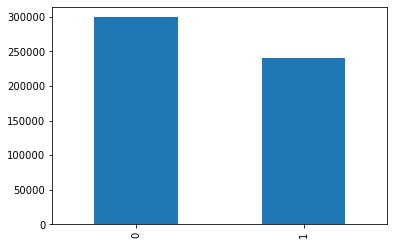

In [9]:
air_bal = df_airlines['Delay'].value_counts()[0] / df_airlines['Delay'].count()
print(f"{air_bal * 100:.2f}% {(1 - air_bal) * 100:.2f}% of disbalancing")

df_airlines['Delay'].value_counts().plot.bar()


#### Resampling

In [10]:
#!pip install imblearn

df_airlines = df_airlines.sample(frac=0.2, random_state=1)

df_airlines.shape


#### Normalizing

In [11]:
air_X = df_airlines.drop(columns=['Delay'])
air_y = df_airlines['Delay']

air_X = (air_X - air_X.mean()) / air_X.std()

air_X = air_X.dropna(axis='columns')

air_X.head()


Flight      Time    Length  Airline_b'9E'  Airline_b'AA'  \
21403  -1.132288 -0.996472  0.559357      -0.200997      -0.304759   
121631 -0.456605 -1.446426  0.531040      -0.200997      -0.304759   
535153  0.773758  0.533369 -0.077782       4.975160      -0.304759   
415037  1.993956  0.857335  0.007170      -0.200997      -0.304759   
69899  -1.106152 -1.230448  0.106280      -0.200997      -0.304759   

        Airline_b'AS'  Airline_b'B6'  Airline_b'CO'  Airline_b'DL'  \
21403       -0.146907      -0.186949      -0.201943      -0.354342   
121631      -0.146907      -0.186949      -0.201943      -0.354342   
535153      -0.146907      -0.186949      -0.201943      -0.354342   
415037      -0.146907      -0.186949      -0.201943      -0.354342   
69899       -0.146907      -0.186949      -0.201943      -0.354342   

        Airline_b'EV'  ...  AirportTo_b'XNA'  AirportTo_b'YAK'  \
21403       -0.233508  ...         -0.047022         -0.010098   
121631      -0.233508  ...         -0.047022         -0.010098   
535153      -0.233508  ...         -0.047022         -0.010098   
415037      -0.233508  ...         -0.047022         -0.010098   
69899       -0.233508  ...         -0.047022         -0.010098   

        AirportTo_b'YUM'  DayOfWeek_b'1'  DayOfWeek_b'2'  DayOfWeek_b'3'  \
21403          -0.026022       -0.394436       -0.388626       -0.446473   
121631         -0.026022       -0.394436       -0.388626        2.239758   
535153         -0.026022       -0.394436       -0.388626       -0.446473   
415037         -0.026022       -0.394436       -0.388626       -0.446473   
69899          -0.026022       -0.394436       -0.388626       -0.446473   

        DayOfWeek_b'4'  DayOfWeek_b'5'  DayOfWeek_b'6'  DayOfWeek_b'7'  
21403         2.199781       -0.434667        -0.34674       -0.387314  
121631       -0.454587       -0.434667        -0.34674       -0.387314  
535153       -0.454587        2.300592        -0.34674       -0.387314  
415037       -0.454587        2.300592        -0.34674       -0.387314  
69899        -0.454587       -0.434667        -0.34674        2.581862  

[5 rows x 611 columns]

### Model Training

#### Decision Tree

[0.63311086 0.64043382 0.63598443 0.63274008 0.63561364 0.64061921
 0.63616982 0.62677297 0.63493094 0.63391119]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


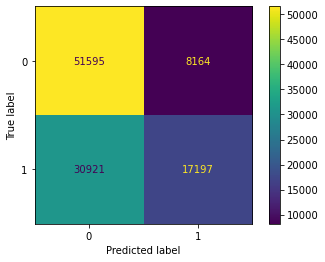

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

air_dt_params_file = "./params/air_decision_tree_grided_cv.json"
air_dt_scores = []

if not exists(air_dt_params_file):
    # instantiating classifier
    air_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    air_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    air_decision_tree_grided_cv = RandomizedSearchCV(air_decision_tree_clf, air_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    air_decision_tree_grided_cv.fit(air_X, air_y)
    # write file with parameters to save on computation next run
    with open(air_dt_params_file, "w+") as param_f:
        json.dump(air_decision_tree_grided_cv.best_params_, param_f, indent=4)

        air_dt_scores = cross_val_score(air_decision_tree_grided_cv, air_X, air_y, cv=10)
        print(air_dt_scores)
        plot_confusion_matrix(air_decision_tree_grided_cv, air_X, air_y)
else:
    # read params file
    with open(air_dt_params_file, "r") as param_f:
        # instantiating classifier
        air_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        air_decision_tree_grided_cv = air_decision_tree_clf.fit(air_X, air_y)

        air_dt_scores = cross_val_score(air_decision_tree_grided_cv, air_X, air_y, cv=10)
        print(air_dt_scores)
        plot_confusion_matrix(air_decision_tree_grided_cv, air_X, air_y)


#### Random Forest

[0.65804598 0.66453467 0.66351502 0.65368928 0.66017798 0.66740823
 0.65489433 0.6562529  0.65736535 0.66005377]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


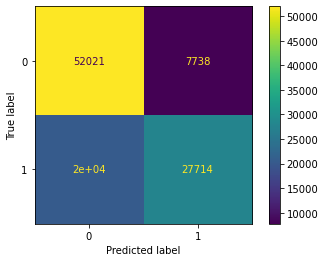

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

air_rf_params_file = "./params/air_random_forest_grided_cv.json"
air_rf_scores = []

if not exists(air_rf_params_file):
    # instantiating classifier
    air_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    air_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    air_random_forest_grided_cv = RandomizedSearchCV(air_random_forest_clf, air_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    air_random_forest_grided_cv.fit(air_X, air_y)

    with open("./params/air_random_forest_grided_cv.json", "w") as param_f:
        json.dump(air_random_forest_grided_cv.best_params_, param_f, indent=4)

        air_rf_scores = cross_val_score(air_random_forest_grided_cv, air_X, air_y, cv=10)
        print(air_rf_scores)
        plot_confusion_matrix(air_random_forest_grided_cv, air_X, air_y)
else:
    with open(air_rf_params_file, "r") as param_f:
        # instantiating classifier
        air_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        air_random_forest_grided_cv = air_random_forest_clf.fit(air_X, air_y)

        air_rf_scores = cross_val_score(air_random_forest_grided_cv, air_X, air_y, cv=10)
        print(air_rf_scores)
        plot_confusion_matrix(air_random_forest_grided_cv, air_X, air_y)


#### KNN

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[0.63515017 0.63051539 0.63014461 0.62152392 0.63477938 0.64330738
 0.62829069 0.62788542 0.63326226 0.63131547]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


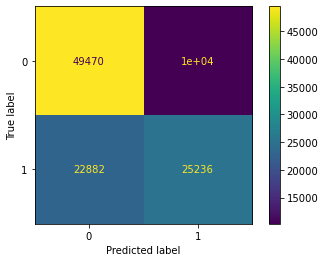

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

air_knn_params_file = "./params/air_knn_grided_cv.json"
air_knn_scores = []

if not exists(air_knn_params_file):
    # instantiating classifier
    air_knn_clf = KNeighborsClassifier()
    # defining testing params
    air_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    air_knn_grided_cv = RandomizedSearchCV(air_knn_clf, air_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    air_knn_grided_cv.fit(air_X, air_y)

    with open("./params/air_knn_grided_cv.json", "w") as param_f:
        json.dump(air_knn_grided_cv.best_params_, param_f, indent=4)

        air_knn_scores = cross_val_score(air_knn_grided_cv, air_X, air_y, cv=10)
        print(air_knn_scores)
        plot_confusion_matrix(air_knn_grided_cv, air_X, air_y)
else:
    with open(air_knn_params_file, "r") as param_f:
        # instantiating classifier
        air_knn_clf = KNeighborsClassifier(**json.load(param_f))
        air_knn_grided_cv = air_knn_clf.fit(air_X, air_y)

        air_knn_scores = cross_val_score(air_knn_grided_cv, air_X, air_y, cv=10)
        print(air_knn_scores)
        plot_confusion_matrix(air_knn_grided_cv, air_X, air_y)


### Model Evaluation

p = 0.0003707435404590862
Rejeita-se a hipótese nula


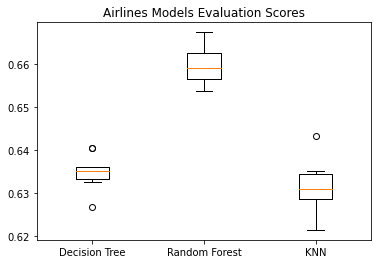

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(air_dt_scores, air_rf_scores, air_knn_scores) 

print(f"p = {p}")
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([air_dt_scores, air_rf_scores, air_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
# plt.ylim(0.8, 1)
plt.title("Airlines Models Evaluation Scores")
plt.show()


## Phoneme

### Dataset Loading and first look

In [16]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/phonemes.arff')
df_phonemes = pd.DataFrame(data[0])

df_phonemes.head()


V1        V2        V3        V4        V5 Class
0  0.489927 -0.451528 -1.047990 -0.598693 -0.020418  b'1'
1 -0.641265  0.109245  0.292130 -0.916804  0.240223  b'1'
2  0.870593 -0.459862  0.578159  0.806634  0.835248  b'1'
3 -0.628439 -0.316284  1.934295 -1.427099 -0.136583  b'1'
4 -0.596399  0.015938  2.043206 -1.688448 -0.948127  b'1'

In [17]:
df_phonemes.describe()


V1            V2            V3            V4            V5
count  5.404000e+03  5.404000e+03  5.404000e+03  5.404000e+03  5.404000e+03
mean   3.330866e-09  5.551443e-09  6.106588e-09 -9.437454e-09 -6.698742e-08
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -2.933743e+00 -3.038709e+00 -2.795869e+00 -2.485340e+00 -2.367461e+00
25%   -6.697555e-01 -7.790800e-01 -9.505788e-01 -7.583255e-01 -5.405418e-01
50%   -3.801605e-01 -2.150985e-01 -3.861800e-02 -1.422555e-01 -2.127475e-01
75%    3.149040e-01  7.136990e-01  7.771393e-01  6.759035e-01  2.045420e-01
max    3.828575e+00  3.664763e+00  2.630868e+00  3.046948e+00  4.586666e+00

### Skimming

In [18]:
# !pip install skimpy
from skimpy import skim

skim(df_phonemes)


╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 5404   │ │ float64     │ 5     │                                    │
│ │ Number of columns │ 6      │ │ object      │ 1     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃     ┃ missing  ┃ complete rate ┃ mean     ┃ sd ┃ p0   ┃ p25   ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ V1  │        0 │             1 │  3.3e-09 │  1 │ -2.9 │ -0.67 │ 0.31 │  3.8 │  ▃█▂▁  │  │
│ │ V2  │        0 │             1 │  5.6e-09 │  1 │   -3 │ -0.78 │ 0.71 │  3.7 │  ▄█▄▂  │  │
│ │ V3  │        0 │             1 │  6.1e-09 │  1 │ -2.8 │ -0.95 │ 0.78 │  2.6 │  ▆▇█▅▁ │  │
│ │ V4  │        0 │             1 │ -9.4e-09 │  1 │ -2.5 │ -0.76 │ 0.68 │    3 │  ██▆▃▁ │  │
│ │ V5  │        0 │             1 │ -6.7e-08 │  1 │ -2.4 │ -0.54 │  0.2 │  4.6 │ ▁█▃▁▁  │  │
│ └─────┴──────────┴───────────────┴──────────┴────┴──────┴───────┴──────┴──────┴────────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

### Preprocessing

#### object columns

In [19]:
pho_obj_cols = list(df_phonemes.columns[df_phonemes.dtypes == object])

df_phonemes[pho_obj_cols].head()


Class
0  b'1'
1  b'1'
2  b'1'
3  b'1'
4  b'1'

In [20]:
df_phonemes['Class'].unique()


array([b'1', b'2'], dtype=object)

In [21]:
# special case for target column
pho_obj_cols.remove('Class')

df_phonemes['Class'] = df_phonemes['Class'].map({b'1': 0, b'2': 1})

df_phonemes.head()


V1        V2        V3        V4        V5  Class
0  0.489927 -0.451528 -1.047990 -0.598693 -0.020418      0
1 -0.641265  0.109245  0.292130 -0.916804  0.240223      0
2  0.870593 -0.459862  0.578159  0.806634  0.835248      0
3 -0.628439 -0.316284  1.934295 -1.427099 -0.136583      0
4 -0.596399  0.015938  2.043206 -1.688448 -0.948127      0

#### Target class balancing

70.65% 29.35% of disbalancing


<AxesSubplot:>

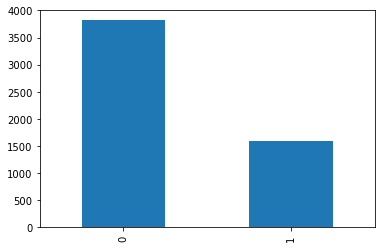

In [22]:
pho_bal = df_phonemes['Class'].value_counts()[0] / df_phonemes['Class'].count()
print(f"{pho_bal * 100:.2f}% {(1 - pho_bal) * 100:.2f}% of disbalancing")

df_phonemes['Class'].value_counts().plot.bar()


50.00% 50.00% of disbalancing


<AxesSubplot:>

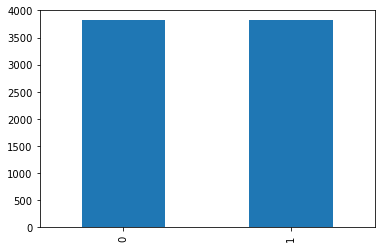

In [23]:
# !pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

df_phonemes_target = df_phonemes['Class']
df_phonemes = df_phonemes.drop(columns=['Class'])
df_phonemes, df_phonemes_target = ros.fit_resample(df_phonemes, df_phonemes_target)

df_phonemes = pd.concat([df_phonemes, df_phonemes_target], axis=1)

pho_bal = df_phonemes['Class'].value_counts()[0] / df_phonemes['Class'].count()
print(f"{pho_bal * 100:.2f}% {(1 - pho_bal) * 100:.2f}% of disbalancing")

df_phonemes['Class'].value_counts().plot.bar()


#### Normalizing

In [24]:
pho_X = df_phonemes.drop(columns=['Class'])
pho_y = df_phonemes['Class']

pho_X = (pho_X - pho_X.mean()) / pho_X.std()

pho_X = pho_X.dropna(axis='columns')

pho_X.head()


V1        V2        V3        V4        V5
0  0.687420 -0.375225 -1.225616 -0.711911 -0.064428
1 -0.582624  0.217558  0.155848 -1.013029  0.168810
2  1.114812 -0.384034  0.450702  0.618345  0.701275
3 -0.568223 -0.232261  1.848677 -1.496064 -0.168380
4 -0.532251  0.118925  1.960948 -1.743452 -0.894599

### Model Training

#### Decision Tree

[0.94109948 0.92146597 0.92146597 0.93324607 0.92670157 0.96204188
 0.95806029 0.9672346  0.95150721 0.95150721]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


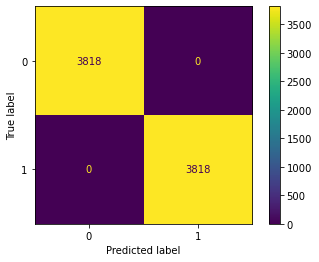

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

pho_dt_params_file = "./params/pho_decision_tree_grided_cv.json"
pho_dt_scores = []

if not exists(pho_dt_params_file):
    # instantiating classifier
    pho_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    pho_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    pho_decision_tree_grided_cv = GridSearchCV(pho_decision_tree_clf, pho_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    pho_decision_tree_grided_cv.fit(pho_X, pho_y)
    # write file with parameters to save on computation next run
    with open(pho_dt_params_file, "w+") as param_f:
        json.dump(pho_decision_tree_grided_cv.best_params_, param_f, indent=4)

        pho_dt_scores = cross_val_score(pho_decision_tree_grided_cv, pho_X, pho_y, cv=10)
        print(pho_dt_scores)
        plot_confusion_matrix(pho_decision_tree_grided_cv, pho_X, pho_y)
else:
    # read params file
    with open(pho_dt_params_file, "r") as param_f:
        # instantiating classifier
        pho_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        pho_decision_tree_grided_cv = pho_decision_tree_clf.fit(pho_X, pho_y)

        pho_dt_scores = cross_val_score(pho_decision_tree_grided_cv, pho_X, pho_y, cv=10)
        print(pho_dt_scores)
        plot_confusion_matrix(pho_decision_tree_grided_cv, pho_X, pho_y)


#### Random Forest

[0.96073298 0.93848168 0.94240838 0.96596859 0.95811518 0.97513089
 0.97116645 0.97771953 0.97116645 0.97116645]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


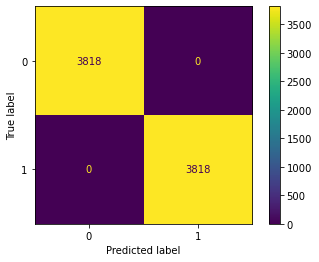

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

pho_rf_params_file = "./params/pho_random_forest_grided_cv.json"
pho_rf_scores = []

if not exists(pho_rf_params_file):
    # instantiating classifier
    pho_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    pho_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    pho_random_forest_grided_cv = GridSearchCV(pho_random_forest_clf, pho_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    pho_random_forest_grided_cv.fit(pho_X, pho_y)

    with open("./params/pho_random_forest_grided_cv.json", "w") as param_f:
        json.dump(pho_random_forest_grided_cv.best_params_, param_f, indent=4)

        pho_rf_scores = cross_val_score(pho_random_forest_grided_cv, pho_X, pho_y, cv=10)
        print(pho_rf_scores)
        plot_confusion_matrix(pho_random_forest_grided_cv, pho_X, pho_y)
else:
    with open(pho_rf_params_file, "r") as param_f:
        # instantiating classifier
        pho_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        pho_random_forest_grided_cv = pho_random_forest_clf.fit(pho_X, pho_y)

        pho_rf_scores = cross_val_score(pho_random_forest_grided_cv, pho_X, pho_y, cv=10)
        print(pho_rf_scores)
        plot_confusion_matrix(pho_random_forest_grided_cv, pho_X, pho_y)


#### KNN

[0.96204188 0.94240838 0.93324607 0.94109948 0.96465969 0.97251309
 0.97116645 0.97903014 0.96985583 0.96592398]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


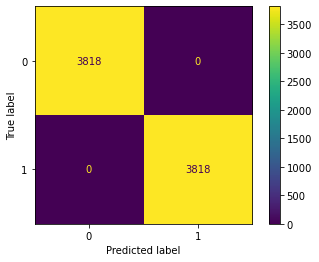

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

pho_knn_params_file = "./params/pho_knn_grided_cv.json"
pho_knn_scores = []

if not exists(pho_knn_params_file):
    # instantiating classifier
    pho_knn_clf = KNeighborsClassifier()
    # defining testing params
    pho_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    pho_knn_grided_cv = GridSearchCV(pho_knn_clf, pho_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    pho_knn_grided_cv.fit(pho_X, pho_y)

    with open("./params/pho_knn_grided_cv.json", "w") as param_f:
        json.dump(pho_knn_grided_cv.best_params_, param_f, indent=4)

        pho_knn_scores = cross_val_score(pho_knn_grided_cv, pho_X, pho_y, cv=10)
        print(pho_knn_scores)
        plot_confusion_matrix(pho_knn_grided_cv, pho_X, pho_y)
else:
    with open(pho_knn_params_file, "r") as param_f:
        # instantiating classifier
        pho_knn_clf = KNeighborsClassifier(**json.load(param_f))
        pho_knn_grided_cv = pho_knn_clf.fit(pho_X, pho_y)

        pho_knn_scores = cross_val_score(pho_knn_grided_cv, pho_X, pho_y, cv=10)
        print(pho_knn_scores)
        plot_confusion_matrix(pho_knn_grided_cv, pho_X, pho_y)


### Model Evaluation

p = 0.00044477202166078673
Rejeita-se a hipótese nula


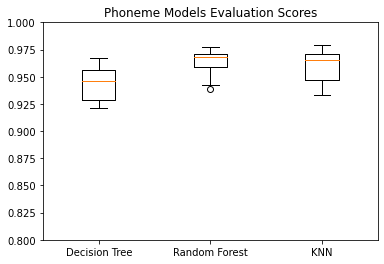

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(pho_dt_scores, pho_rf_scores, pho_knn_scores) 

print(f"p = {p}")
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([pho_dt_scores, pho_rf_scores, pho_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
plt.ylim(0.8, 1)
plt.title("Phoneme Models Evaluation Scores")
plt.show()


## Phishing Websites

### Dataset loading and first look

In [29]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/phishing.arff')
df_phishing = pd.DataFrame(data[0])

df_phishing.head()


having_IP_Address URL_Length Shortining_Service having_At_Symbol  \
0             b'-1'       b'1'               b'1'             b'1'   
1              b'1'       b'1'               b'1'             b'1'   
2              b'1'       b'0'               b'1'             b'1'   
3              b'1'       b'0'               b'1'             b'1'   
4              b'1'       b'0'              b'-1'             b'1'   

  double_slash_redirecting Prefix_Suffix having_Sub_Domain SSLfinal_State  \
0                    b'-1'         b'-1'             b'-1'          b'-1'   
1                     b'1'         b'-1'              b'0'           b'1'   
2                     b'1'         b'-1'             b'-1'          b'-1'   
3                     b'1'         b'-1'             b'-1'          b'-1'   
4                     b'1'         b'-1'              b'1'           b'1'   

  Domain_registeration_length Favicon  ... popUpWidnow Iframe age_of_domain  \
0                       b'-1'    b'1'  ...        b'1'   b'1'         b'-1'   
1                       b'-1'    b'1'  ...        b'1'   b'1'         b'-1'   
2                       b'-1'    b'1'  ...        b'1'   b'1'          b'1'   
3                        b'1'    b'1'  ...        b'1'   b'1'         b'-1'   
4                       b'-1'    b'1'  ...       b'-1'   b'1'         b'-1'   

  DNSRecord web_traffic Page_Rank Google_Index Links_pointing_to_page  \
0     b'-1'       b'-1'     b'-1'         b'1'                   b'1'   
1     b'-1'        b'0'     b'-1'         b'1'                   b'1'   
2     b'-1'        b'1'     b'-1'         b'1'                   b'0'   
3     b'-1'        b'1'     b'-1'         b'1'                  b'-1'   
4     b'-1'        b'0'     b'-1'         b'1'                   b'1'   

  Statistical_report Result  
0              b'-1'  b'-1'  
1               b'1'  b'-1'  
2              b'-1'  b'-1'  
3               b'1'  b'-1'  
4               b'1'   b'1'  

[5 rows x 31 columns]

In [30]:
df_phishing.describe()


having_IP_Address URL_Length Shortining_Service having_At_Symbol  \
count              11055      11055              11055            11055   
unique                 2          3                  2                2   
top                 b'1'      b'-1'               b'1'             b'1'   
freq                7262       8960               9611             9400   

       double_slash_redirecting Prefix_Suffix having_Sub_Domain  \
count                     11055         11055             11055   
unique                        2             2                 3   
top                        b'1'         b'-1'              b'1'   
freq                       9626          9590              4070   

       SSLfinal_State Domain_registeration_length Favicon  ... popUpWidnow  \
count           11055                       11055   11055  ...       11055   
unique              3                           2       2  ...           2   
top              b'1'                       b'-1'    b'1'  ...        b'1'   
freq             6331                        7389    9002  ...        8918   

       Iframe age_of_domain DNSRecord web_traffic Page_Rank Google_Index  \
count   11055         11055     11055       11055     11055        11055   
unique      2             2         2           3         2            2   
top      b'1'          b'1'      b'1'        b'1'     b'-1'         b'1'   
freq    10043          5866      7612        5831      8201         9516   

       Links_pointing_to_page Statistical_report Result  
count                   11055              11055  11055  
unique                      3                  2      2  
top                      b'0'               b'1'   b'1'  
freq                     6156               9505   6157  

[4 rows x 31 columns]

### Preprocessing

#### object columns

In [31]:
phi_obj_cols = list(df_phishing.columns[df_phishing.dtypes == object])

df_phishing[phi_obj_cols].head()


having_IP_Address URL_Length Shortining_Service having_At_Symbol  \
0             b'-1'       b'1'               b'1'             b'1'   
1              b'1'       b'1'               b'1'             b'1'   
2              b'1'       b'0'               b'1'             b'1'   
3              b'1'       b'0'               b'1'             b'1'   
4              b'1'       b'0'              b'-1'             b'1'   

  double_slash_redirecting Prefix_Suffix having_Sub_Domain SSLfinal_State  \
0                    b'-1'         b'-1'             b'-1'          b'-1'   
1                     b'1'         b'-1'              b'0'           b'1'   
2                     b'1'         b'-1'             b'-1'          b'-1'   
3                     b'1'         b'-1'             b'-1'          b'-1'   
4                     b'1'         b'-1'              b'1'           b'1'   

  Domain_registeration_length Favicon  ... popUpWidnow Iframe age_of_domain  \
0                       b'-1'    b'1'  ...        b'1'   b'1'         b'-1'   
1                       b'-1'    b'1'  ...        b'1'   b'1'         b'-1'   
2                       b'-1'    b'1'  ...        b'1'   b'1'          b'1'   
3                        b'1'    b'1'  ...        b'1'   b'1'         b'-1'   
4                       b'-1'    b'1'  ...       b'-1'   b'1'         b'-1'   

  DNSRecord web_traffic Page_Rank Google_Index Links_pointing_to_page  \
0     b'-1'       b'-1'     b'-1'         b'1'                   b'1'   
1     b'-1'        b'0'     b'-1'         b'1'                   b'1'   
2     b'-1'        b'1'     b'-1'         b'1'                   b'0'   
3     b'-1'        b'1'     b'-1'         b'1'                  b'-1'   
4     b'-1'        b'0'     b'-1'         b'1'                   b'1'   

  Statistical_report Result  
0              b'-1'  b'-1'  
1               b'1'  b'-1'  
2              b'-1'  b'-1'  
3               b'1'  b'-1'  
4               b'1'   b'1'  

[5 rows x 31 columns]

In [32]:
phi_unary_cols = []

for col in phi_obj_cols:
    curr_col_uniques = len(df_phishing[col].unique())
    # if is a binary column
    if curr_col_uniques == 2 or curr_col_uniques == 3:
        bin_values = df_phishing[col].unique()
        df_phishing[col] = df_phishing[col].map(lambda v: int(v))
    # if column is unary
    elif len(df_phishing[col].unique()) == 1:
        phi_unary_cols.append(col)
    # print problematic column
    else:
        print(col, len(df_phishing[col].unique()))

# removing unary cols
df_phishing = df_phishing.drop(columns=phi_unary_cols)

phi_obj_cols = [col for col in phi_obj_cols if col not in phi_unary_cols]
df_phishing[phi_obj_cols].head()


having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  ...  popUpWidnow  Iframe  \
0                           -1        1  ...            1       1   
1                           -1        1  ...            1       1   
2                           -1        1  ...            1       1   
3                            1        1  ...            1       1   
4                           -1        1  ...           -1       1   

   age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
0             -1         -1           -1         -1             1   
1             -1         -1            0         -1             1   
2              1         -1            1         -1             1   
3             -1         -1            1         -1             1   
4             -1         -1            0         -1             1   

   Links_pointing_to_page  Statistical_report  Result  
0                       1                  -1      -1  
1                       1                   1      -1  
2                       0                  -1      -1  
3                      -1                   1      -1  
4                       1                   1       1  

[5 rows x 31 columns]

#### Target class balancing

55.69% 44.31% of disbalancing


<AxesSubplot:>

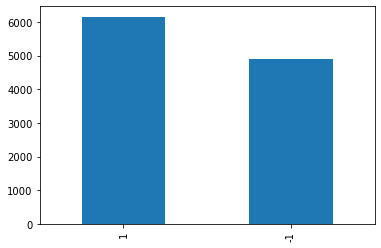

In [33]:
phi_bal = df_phishing['Result'].value_counts()[1] / df_phishing['Result'].count()
print(f"{phi_bal * 100:.2f}% {(1 - phi_bal) * 100:.2f}% of disbalancing")

df_phishing['Result'].value_counts().plot.bar()


#### Normalizing

In [34]:
phi_X = df_phishing.drop(columns=['Result'])
phi_y = df_phishing['Result']

phi_X = (phi_X - phi_X.mean()) / phi_X.std()

phi_X = phi_X.dropna(axis='columns')

phi_X.head()


having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0          -1.383621    2.131846            0.387596          0.419581   
1           0.722676    2.131846            0.387596          0.419581   
2           0.722676    0.826526            0.387596          0.419581   
3           0.722676    0.826526            0.387596          0.419581   
4           0.722676    0.826526           -2.579770          0.419581   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                 -2.595298      -0.390832          -1.301443       -1.371793   
1                  0.385277      -0.390832          -0.078228        0.821449   
2                  0.385277      -0.390832          -1.301443       -1.371793   
3                  0.385277      -0.390832          -1.301443       -1.371793   
4                  0.385277      -0.390832           1.144986        0.821449   

   Domain_registeration_length   Favicon  ...  RightClick  popUpWidnow  \
0                    -0.704342  0.477535  ...     0.21211     0.489496   
1                    -0.704342  0.477535  ...     0.21211     0.489496   
2                    -0.704342  0.477535  ...     0.21211     0.489496   
3                     1.419636  0.477535  ...     0.21211     0.489496   
4                    -0.704342  0.477535  ...     0.21211    -2.042734   

     Iframe  age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
0  0.317423      -1.063187   -1.48683    -1.555200  -0.589894      0.402136   
1  0.317423      -1.063187   -1.48683    -0.347081  -0.589894      0.402136   
2  0.317423       0.940483   -1.48683     0.861037  -0.589894      0.402136   
3  0.317423      -1.063187   -1.48683     0.861037  -0.589894      0.402136   
4  0.317423      -1.063187   -1.48683    -0.347081  -0.589894      0.402136   

   Links_pointing_to_page  Statistical_report  
0                1.150977           -2.476228  
1                1.150977            0.403804  
2               -0.603581           -2.476228  
3               -2.358139            0.403804  
4                1.150977            0.403804  

[5 rows x 30 columns]

### Model Training

#### Decision Tree

[0.98553345 0.98191682 0.97106691 0.98372514 0.97468354 0.96832579
 0.94208145 0.93574661 0.94841629 0.94479638]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


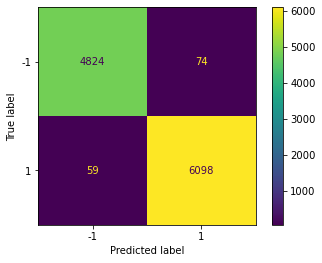

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

phi_dt_params_file = "./params/phi_decision_tree_grided_cv.json"
phi_dt_scores = []

if not exists(phi_dt_params_file):
    # instantiating classifier
    phi_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    phi_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    phi_decision_tree_grided_cv = GridSearchCV(phi_decision_tree_clf, phi_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    phi_decision_tree_grided_cv.fit(phi_X, phi_y)
    # write file with parameters to save on computation next run
    with open(phi_dt_params_file, "w+") as param_f:
        json.dump(phi_decision_tree_grided_cv.best_params_, param_f, indent=4)

        phi_dt_scores = cross_val_score(phi_decision_tree_grided_cv, phi_X, phi_y, cv=10)
        print(phi_dt_scores)
        plot_confusion_matrix(phi_decision_tree_grided_cv, phi_X, phi_y)
else:
    # read params file
    with open(phi_dt_params_file, "r") as param_f:
        # instantiating classifier
        phi_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        phi_decision_tree_grided_cv = phi_decision_tree_clf.fit(phi_X, phi_y)

        phi_dt_scores = cross_val_score(phi_decision_tree_grided_cv, phi_X, phi_y, cv=10)
        print(phi_dt_scores)
        plot_confusion_matrix(phi_decision_tree_grided_cv, phi_X, phi_y)


#### Random Forest

[0.98553345 0.98372514 0.97377939 0.98372514 0.98282098 0.97375566
 0.96742081 0.95656109 0.9638009  0.96561086]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


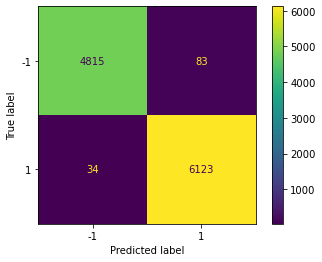

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

phi_rf_params_file = "./params/phi_random_forest_grided_cv.json"
phi_rf_scores = []

if not exists(phi_rf_params_file):
    # instantiating classifier
    phi_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    phi_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    phi_random_forest_grided_cv = GridSearchCV(phi_random_forest_clf, phi_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    phi_random_forest_grided_cv.fit(phi_X, phi_y)

    with open("./params/phi_random_forest_grided_cv.json", "w") as param_f:
        json.dump(phi_random_forest_grided_cv.best_params_, param_f, indent=4)

        phi_rf_scores = cross_val_score(phi_random_forest_grided_cv, phi_X, phi_y, cv=10)
        print(phi_rf_scores)
        plot_confusion_matrix(phi_random_forest_grided_cv, phi_X, phi_y)
else:
    with open(phi_rf_params_file, "r") as param_f:
        # instantiating classifier
        phi_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        phi_random_forest_grided_cv = phi_random_forest_clf.fit(phi_X, phi_y)

        phi_rf_scores = cross_val_score(phi_random_forest_grided_cv, phi_X, phi_y, cv=10)
        print(phi_rf_scores)
        plot_confusion_matrix(phi_random_forest_grided_cv, phi_X, phi_y)


#### KNN

[0.98191682 0.98282098 0.97106691 0.98915009 0.97830018 0.95022624
 0.93574661 0.9520362  0.9438914  0.95746606]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


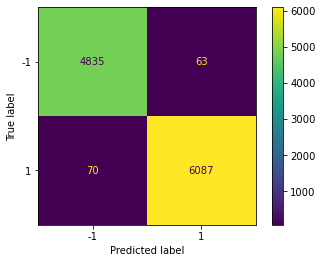

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

phi_knn_params_file = "./params/phi_knn_grided_cv.json"
phi_knn_scores = []

if not exists(phi_knn_params_file):
    # instantiating classifier
    phi_knn_clf = KNeighborsClassifier()
    # defining testing params
    phi_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    phi_knn_grided_cv = GridSearchCV(phi_knn_clf, phi_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    phi_knn_grided_cv.fit(phi_X, phi_y)

    with open("./params/phi_knn_grided_cv.json", "w") as param_f:
        json.dump(phi_knn_grided_cv.best_params_, param_f, indent=4)

        phi_knn_scores = cross_val_score(phi_knn_grided_cv, phi_X, phi_y, cv=10)
        print(phi_knn_scores)
        plot_confusion_matrix(phi_knn_grided_cv, phi_X, phi_y)
else:
    with open(phi_knn_params_file, "r") as param_f:
        # instantiating classifier
        phi_knn_clf = KNeighborsClassifier(**json.load(param_f))
        phi_knn_grided_cv = phi_knn_clf.fit(phi_X, phi_y)

        phi_knn_scores = cross_val_score(phi_knn_grided_cv, phi_X, phi_y, cv=10)
        print(phi_knn_scores)
        plot_confusion_matrix(phi_knn_grided_cv, phi_X, phi_y)


### Model Evaluation

p = 0.00542782804798967
Rejeita-se a hipótese nula


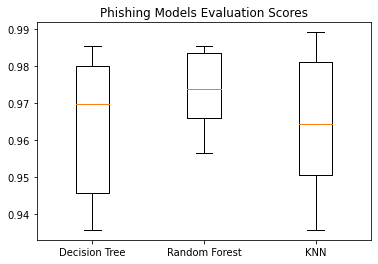

In [38]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(phi_dt_scores, phi_rf_scores, phi_knn_scores) 

print(f"p = {p}")
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([phi_dt_scores, phi_rf_scores, phi_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
# plt.ylim(0.8, 1)
plt.title("Phishing Models Evaluation Scores")
plt.show()


## Satellite

### Dataset loading and first look

In [39]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/satellite.arff')
df_satellite = pd.DataFrame(data[0])

df_satellite.head()


V1    V2     V3     V4    V5    V6     V7     V8    V9   V10  ...    V28  \
0  46.0  40.0  119.0  139.0  42.0  30.0  135.0  157.0  42.0  30.0  ...  113.0   
1  47.0  37.0  119.0  133.0  44.0  34.0  124.0  143.0  44.0  34.0  ...   85.0   
2  80.0  95.0  100.0   74.0  64.0  64.0  104.0   96.0  46.0  36.0  ...   81.0   
3  56.0  51.0   72.0   60.0  59.0  54.0   72.0   60.0  59.0  51.0  ...   50.0   
4  44.0  34.0  129.0  140.0  44.0  34.0  124.0  136.0  44.0  34.0  ...  139.0   

    V29   V30    V31    V32   V33   V34    V35    V36      Target  
0  50.0  46.0  111.0  116.0  44.0  31.0  131.0  142.0  b'Anomaly'  
1  50.0  39.0  118.0  132.0  43.0  29.0  133.0  143.0  b'Anomaly'  
2  82.0  91.0   92.0   78.0  78.0  83.0   96.0   74.0  b'Anomaly'  
3  57.0  55.0   74.0   61.0  57.0  55.0   78.0   65.0  b'Anomaly'  
4  43.0  31.0  128.0  135.0  43.0  29.0  128.0  132.0  b'Anomaly'  

[5 rows x 37 columns]

In [40]:
df_satellite.describe()

V1           V2           V3           V4           V5  \
count  5100.000000  5100.000000  5100.000000  5100.000000  5100.000000   
mean     73.092157    91.578431    99.568627    79.827059    72.957843   
std      11.876090    16.038819    15.611375    13.513639    11.772122   
min      41.000000    28.000000    62.000000    44.000000    42.000000   
25%      64.000000    79.000000    87.000000    70.000000    64.000000   
50%      71.000000    92.000000   101.000000    81.000000    71.000000   
75%      84.000000   106.000000   113.000000    90.000000    83.000000   
max     104.000000   137.000000   139.000000   144.000000   104.000000   

                V6           V7           V8           V9          V10  ...  \
count  5100.000000  5100.000000  5100.000000  5100.000000  5100.000000  ...   
mean     91.425686    99.357843    79.643725    72.608039    90.861765  ...   
std      15.823086    15.585557    13.447272    11.716109    16.071067  ...   
min      29.000000    62.000000    46.000000    42.000000    29.000000  ...   
25%      79.000000    86.000000    69.000000    64.000000    79.000000  ...   
50%      92.000000   101.000000    81.000000    71.000000    91.000000  ...   
75%     106.000000   113.000000    90.000000    83.000000   104.000000  ...   
max     137.000000   139.000000   157.000000   104.000000   130.000000  ...   

               V27          V28          V29          V30          V31  \
count  5100.000000  5100.000000  5100.000000  5100.000000  5100.000000   
mean     99.244902    79.695686    72.590588    91.187843    99.207451   
std      15.721836    13.749900    11.815466    15.915964    15.735910   
min      60.000000    44.000000    41.000000    27.000000    62.000000   
25%      86.000000    69.000000    64.000000    79.000000    86.000000   
50%     101.000000    81.000000    71.000000    91.500000   101.000000   
75%     113.000000    90.000000    83.000000   104.000000   113.000000   
max     139.000000   151.000000   104.000000   130.000000   139.000000   

               V32          V33          V34          V35          V36  
count  5100.000000  5100.000000  5100.000000  5100.000000  5100.000000  
mean     79.615294    72.357647    90.856667    98.984510    79.492941  
std      13.626149    11.711489    15.921349    15.712095    13.707023  
min      42.000000    40.000000    27.000000    50.000000    29.000000  
25%      69.000000    64.000000    79.000000    86.000000    68.000000  
50%      81.000000    71.000000    91.000000   100.000000    81.000000  
75%      90.000000    82.000000   104.000000   112.000000    90.000000  
max     151.000000   104.000000   130.000000   138.000000   147.000000  

[8 rows x 36 columns]

### Skimming

In [41]:
# !pip install skimpy
from skimpy import skim

skim(df_satellite)


╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 5100   │ │ float64     │ 36    │                                    │
│ │ Number of columns │ 37     │ │ object      │ 1     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━┳━━━━━┳━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃      ┃ missing   ┃ complete rate   ┃ mean  ┃ sd  ┃ p0  ┃ p25  ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━╇━━━━━╇━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ V1   │         0 │               1 │    73 │  12 │  41 │   64 │   84 │  100 │ ▁▂█▄▅▁ │  │
│ │ V2   │         0 │               1 │    92 │  16 │  28 │   79 │  110 │  140 │   ▇██  │  │
│ │ V3   │         0 │               1 │   100 │  16 │  62 │   87 │  110 │  140 │ ▂▅▆█▆▁ │  │
│ │ V4   │         0 │               1 │    80 │  14 │  44 │   70 │   90 │  140 │  ▂▅█▃  │  │
│ │ V5   │         0 │               1 │    73 │  12 │  42 │   64 │   83 │  100 │ ▁▂█▄▄  │  │
│ │ V6   │         0 │               1 │    91 │  16 │  29 │   79 │  110 │  140 │  ▁▇██  │  │
│ │ V7   │         0 │               1 │    99 │  16 │  62 │   86 │  110 │  140 │ ▂▅▆█▅  │  │
│ │ V8   │         0 │               1 │    80 │  13 │  46 │   69 │   90 │  160 │  ▃▆█   │  │
│ │ V9   │         0 │               1 │    73 │  12 │  42 │   64 │   83 │  100 │ ▁▂█▄▄  │  │
│ │ V10  │         0 │               1 │    91 │  16 │  29 │   79 │  100 │  130 │   ▆▆█▁ │  │
│ │ V11  │         0 │               1 │    99 │  16 │  60 │   86 │  110 │  140 │ ▁▅▅█▅  │  │
│ │ V12  │         0 │               1 │    79 │  14 │  34 │   68 │   90 │  150 │   ▅█▃  │  │
│ │ V13  │         0 │               1 │    73 │  12 │  41 │   64 │   83 │  100 │ ▁▂█▄▅▁ │  │
│ │ V14  │         0 │               1 │    92 │  16 │  27 │   79 │  110 │  140 │   ▇██  │  │
│ │ V15  │         0 │               1 │    99 │  16 │  62 │   86 │  110 │  140 │ ▂▆▆█▆  │  │
│ │ V16  │         0 │               1 │    80 │  14 │  44 │   69 │   90 │  150 │  ▂▆█▁  │  │
│ │ V17  │         0 │               1 │    73 │  12 │  41 │   64 │   83 │  100 │ ▁▂█▄▄  │  │
│ │ V18  │         0 │               1 │    92 │  16 │  27 │   79 │  110 │  130 │   ▄▇█▁ │  │
│ │ V19  │         0 │               1 │    99 │  16 │  62 │   86 │  110 │  140 │ ▂▆▆█▆  │  │
│ │ V20  │         0 │               1 │    80 │  14 │  44 │   69 │   90 │  150 │  ▂▅█▂  │  │
│ │ V21  │         0 │               1 │    73 │  12 │  42 │   64 │   82 │  100 │ ▁▂█▄▄  │  │
│ │ V22  │         0 │               1 │    91 │  16 │  29 │   79 │  100 │  130 │   ▆▆█▁ │  │
│ │ V23  │         0 │               1 │    99 │  16 │  60 │   86 │  110 │  140 │ ▁▆▇██▁ │  │
│ │ V24  │         0 │               1 │    79 │  14 │  34 │   68 │   90 │  150 │   ▅█▄  │  │
│ │ V25  │         0 │               1 │    73 │  12 │  40 │   64 │   83 │  100 │ ▁▂█▄▅▁ │  │
│ │ V26  │         0 │               1 │    91 │  16 │  27 │   79 │  100 │  130 │   ▅▇█▁ │  │
│ │ V27  │         0 │               1 │    99 │  16 │  60 │   86 │  110 │  140 │ ▁▆▅█▆  │  │
│ │ V28  │         0 │               1 │    80 │  14 │  44 │   69 │   90 │  150 │  ▂▆█▁  │  │
│ │ V29  │         0 │               1 │    73 │  12 │  41 │   64 │   83 │  100 │ ▁▂█▃▄  │  │
│ │ V30  │         0 │               1 │    91 │  16 │  27 │   79 │  100 │  130 │   ▅▇█▁ │  │
│ │ V31  │         0 │               1 │    99 │  16

### Preprocessing

#### object columns

In [42]:
sat_obj_cols = list(df_satellite.columns[df_satellite.dtypes == object])

df_satellite[sat_obj_cols].head()


Target
0  b'Anomaly'
1  b'Anomaly'
2  b'Anomaly'
3  b'Anomaly'
4  b'Anomaly'

In [43]:
df_satellite['Target'].unique()


array([b'Anomaly', b'Normal'], dtype=object)

In [44]:
# special case for target column
sat_obj_cols.remove('Target')

df_satellite['Target'] = df_satellite['Target'].map({b'Anomaly': 0, b'Normal': 1})

df_satellite.head()


V1    V2     V3     V4    V5    V6     V7     V8    V9   V10  ...    V28  \
0  46.0  40.0  119.0  139.0  42.0  30.0  135.0  157.0  42.0  30.0  ...  113.0   
1  47.0  37.0  119.0  133.0  44.0  34.0  124.0  143.0  44.0  34.0  ...   85.0   
2  80.0  95.0  100.0   74.0  64.0  64.0  104.0   96.0  46.0  36.0  ...   81.0   
3  56.0  51.0   72.0   60.0  59.0  54.0   72.0   60.0  59.0  51.0  ...   50.0   
4  44.0  34.0  129.0  140.0  44.0  34.0  124.0  136.0  44.0  34.0  ...  139.0   

    V29   V30    V31    V32   V33   V34    V35    V36  Target  
0  50.0  46.0  111.0  116.0  44.0  31.0  131.0  142.0       0  
1  50.0  39.0  118.0  132.0  43.0  29.0  133.0  143.0       0  
2  82.0  91.0   92.0   78.0  78.0  83.0   96.0   74.0       0  
3  57.0  55.0   74.0   61.0  57.0  55.0   78.0   65.0       0  
4  43.0  31.0  128.0  135.0  43.0  29.0  128.0  132.0       0  

[5 rows x 37 columns]

#### Target class balancing

98.53% 1.47% of disbalancing


<AxesSubplot:>

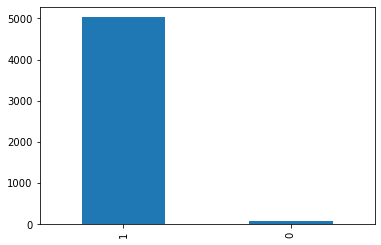

In [45]:
sat_bal = df_satellite['Target'].value_counts()[1] / df_satellite['Target'].count()
print(f"{sat_bal * 100:.2f}% {(1 - sat_bal) * 100:.2f}% of disbalancing")

df_satellite['Target'].value_counts().plot.bar()


counts:
0    501
1    501
Name: Target, dtype: int64
50.00% 50.00% of disbalancing


<AxesSubplot:>

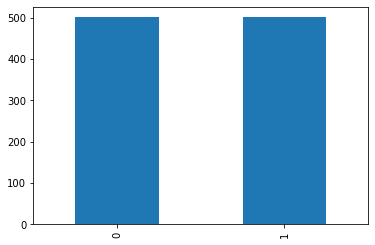

In [46]:
# !pip install imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

smote_tmk = SMOTETomek(sampling_strategy=0.1)
rus = RandomUnderSampler(random_state=0)

df_satellite_target = df_satellite['Target']
df_satellite = df_satellite.drop(columns=['Target'])
df_satellite, df_satellite_target = smote_tmk.fit_resample(df_satellite, df_satellite_target)
df_satellite, df_satellite_target = rus.fit_resample(df_satellite, df_satellite_target)

df_satellite = pd.concat([df_satellite, df_satellite_target], axis=1)

sat_bal = df_satellite['Target'].value_counts()[0] / df_satellite['Target'].count()
print(f"counts:\n{df_satellite['Target'].value_counts()}")
print(f"{sat_bal * 100:.2f}% {(1 - sat_bal) * 100:.2f}% of disbalancing")

df_satellite['Target'].value_counts().plot.bar()


#### Normalizing

In [47]:
sat_X = df_satellite.drop(columns=['Target'])
sat_y = df_satellite['Target']

sat_X = (sat_X - sat_X.mean()) / sat_X.std()

sat_X = sat_X.dropna(axis='columns')

sat_X.head()


V1        V2        V3        V4        V5        V6        V7  \
0 -1.297787 -1.289622  1.166944  2.325388 -1.602310 -1.732969  2.148428   
1 -1.228690 -1.405616  1.166944  2.057127 -1.459611 -1.572728  1.490616   
2  1.051512  0.836932  0.023354 -0.580777 -0.032618 -0.370922  0.294596   
3 -0.606817 -0.864311 -1.661937 -1.206720 -0.389366 -0.771524 -1.619037   
4 -1.435981 -1.521609  1.768834  2.370098 -1.459611 -1.572728  1.490616   

         V8        V9       V10  ...       V27       V28       V29       V30  \
0  3.137811 -1.651617 -1.759465  ...  0.893887  1.076349 -0.948059 -1.014363   
1  2.514425 -1.505470 -1.597159  ...  0.013076 -0.130987 -0.948059 -1.285330   
2  0.421630 -1.359323 -1.516006  ...  0.013076 -0.303463  1.321183  0.727564   
3 -1.181362 -0.409369 -0.907360  ... -1.689826 -1.640156 -0.451662 -0.665978   
4  2.202732 -1.505470 -1.597159  ...  1.950861  2.197446 -1.444455 -1.595006   

        V31       V32       V33       V34       V35       V36  
0  0.689250  1.279476 -1.390505 -1.603601  1.855092  2.381785  
1  1.097579  1.988537 -1.461967 -1.681267  1.971198  2.424960  
2 -0.419073 -0.404543  1.039190  0.415732 -0.176763 -0.554094  
3 -1.469063 -1.157919 -0.461504 -0.671601 -1.221716 -0.942666  
4  1.680907  2.121485 -1.461967 -1.681267  1.680933  1.950038  

[5 rows x 36 columns]

### Model Training

#### Decision Tree

[0.93069307 0.94059406 0.98       0.95       0.99       0.95
 0.99       0.97       0.95       0.97      ]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


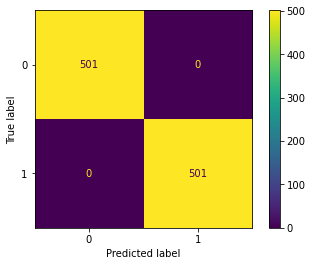

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

sat_dt_params_file = "./params/sat_decision_tree_grided_cv.json"
sat_dt_scores = []

if not exists(sat_dt_params_file):
    # instantiating classifier
    sat_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    sat_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    sat_decision_tree_grided_cv = GridSearchCV(sat_decision_tree_clf, sat_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    sat_decision_tree_grided_cv.fit(sat_X, sat_y)
    # write file with parameters to save on computation next run
    with open(sat_dt_params_file, "w+") as param_f:
        json.dump(sat_decision_tree_grided_cv.best_params_, param_f, indent=4)

        sat_dt_scores = cross_val_score(sat_decision_tree_grided_cv, sat_X, sat_y, cv=10)
        print(sat_dt_scores)
        plot_confusion_matrix(sat_decision_tree_grided_cv, sat_X, sat_y)
else:
    # read params file
    with open(sat_dt_params_file, "r") as param_f:
        # instantiating classifier
        sat_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        sat_decision_tree_grided_cv = sat_decision_tree_clf.fit(sat_X, sat_y)

        sat_dt_scores = cross_val_score(sat_decision_tree_grided_cv, sat_X, sat_y, cv=10)
        print(sat_dt_scores)
        plot_confusion_matrix(sat_decision_tree_grided_cv, sat_X, sat_y)


#### Random Forest

[0.97029703 0.97029703 0.99       0.98       0.99       0.99
 0.99       0.99       0.96       0.99      ]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


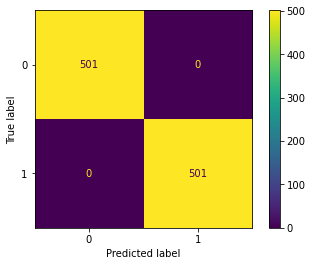

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

sat_rf_params_file = "./params/sat_random_forest_grided_cv.json"
sat_rf_scores = []

if not exists(sat_rf_params_file):
    # instantiating classifier
    sat_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    sat_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    sat_random_forest_grided_cv = GridSearchCV(sat_random_forest_clf, sat_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    sat_random_forest_grided_cv.fit(sat_X, sat_y)

    with open("./params/sat_random_forest_grided_cv.json", "w") as param_f:
        json.dump(sat_random_forest_grided_cv.best_params_, param_f, indent=4)

        sat_rf_scores = cross_val_score(sat_random_forest_grided_cv, sat_X, sat_y, cv=10)
        print(sat_rf_scores)
        plot_confusion_matrix(sat_random_forest_grided_cv, sat_X, sat_y)
else:
    with open(sat_rf_params_file, "r") as param_f:
        # instantiating classifier
        sat_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        sat_random_forest_grided_cv = sat_random_forest_clf.fit(sat_X, sat_y)

        sat_rf_scores = cross_val_score(sat_random_forest_grided_cv, sat_X, sat_y, cv=10)
        print(sat_rf_scores)
        plot_confusion_matrix(sat_random_forest_grided_cv, sat_X, sat_y)


#### KNN

[1.         0.99009901 0.99       0.98       1.         1.
 0.99       0.97       0.98       0.98      ]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


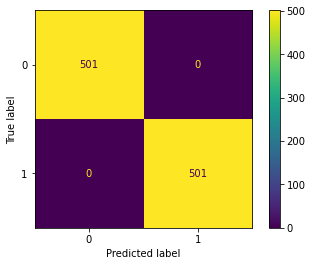

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

sat_knn_params_file = "./params/sat_knn_grided_cv.json"
sat_knn_scores = []

if not exists(sat_knn_params_file):
    # instantiating classifier
    sat_knn_clf = KNeighborsClassifier()
    # defining testing params
    sat_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    sat_knn_grided_cv = GridSearchCV(sat_knn_clf, sat_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    sat_knn_grided_cv.fit(sat_X, sat_y)

    with open("./params/sat_knn_grided_cv.json", "w") as param_f:
        json.dump(sat_knn_grided_cv.best_params_, param_f, indent=4)

        sat_knn_scores = cross_val_score(sat_knn_grided_cv, sat_X, sat_y, cv=10)
        print(sat_knn_scores)
        plot_confusion_matrix(sat_knn_grided_cv, sat_X, sat_y)
else:
    with open(sat_knn_params_file, "r") as param_f:
        # instantiating classifier
        sat_knn_clf = KNeighborsClassifier(**json.load(param_f))
        sat_knn_grided_cv = sat_knn_clf.fit(sat_X, sat_y)

        sat_knn_scores = cross_val_score(sat_knn_grided_cv, sat_X, sat_y, cv=10)
        print(sat_knn_scores)
        plot_confusion_matrix(sat_knn_grided_cv, sat_X, sat_y)


### Model Evaluation

p = 0.0018710603064642064
Rejeita-se a hipótese nula


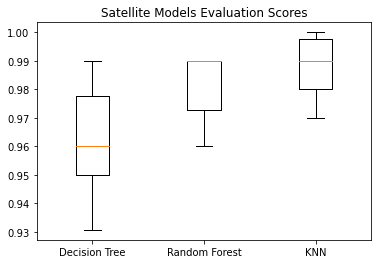

In [51]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(sat_dt_scores, sat_rf_scores, sat_knn_scores) 

print(f"p = {p}")
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([sat_dt_scores, sat_rf_scores, sat_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
# plt.ylim(0.8, 1)
plt.title("Satellite Models Evaluation Scores")
plt.show()


## Adult

### Dataset loading and first look

In [52]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/adult.arff')
df_adult = pd.DataFrame(data[0])

df_adult.head()


age     workclass    fnlwgt        education  education-num  \
0  25.0    b'Private'  226802.0          b'11th'            7.0   
1  38.0    b'Private'   89814.0       b'HS-grad'            9.0   
2  28.0  b'Local-gov'  336951.0    b'Assoc-acdm'           12.0   
3  44.0    b'Private'  160323.0  b'Some-college'           10.0   
4  18.0          b'?'  103497.0  b'Some-college'           10.0   

          marital-status            occupation  relationship      race  \
0       b'Never-married'  b'Machine-op-inspct'  b'Own-child'  b'Black'   
1  b'Married-civ-spouse'    b'Farming-fishing'    b'Husband'  b'White'   
2  b'Married-civ-spouse'    b'Protective-serv'    b'Husband'  b'White'   
3  b'Married-civ-spouse'  b'Machine-op-inspct'    b'Husband'  b'Black'   
4       b'Never-married'                  b'?'  b'Own-child'  b'White'   

         sex  capital-gain  capital-loss  hours-per-week    native-country  \
0    b'Male'           0.0           0.0            40.0  b'United-States'   
1    b'Male'           0.0           0.0            50.0  b'United-States'   
2    b'Male'           0.0           0.0            40.0  b'United-States'   
3    b'Male'        7688.0           0.0            40.0  b'United-States'   
4  b'Female'           0.0           0.0            30.0  b'United-States'   

      class  
0  b'<=50K'  
1  b'<=50K'  
2   b'>50K'  
3   b'>50K'  
4  b'<=50K'

In [53]:
df_adult.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

### Skimming

In [54]:
# !pip install skimpy
from skimpy import skim

skim(df_adult)


╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 48842  │ │ object      │ 9     │                                    │
│ │ Number of columns │ 15     │ │ float64     │ 6     │                                    │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┓  │
│ ┃        ┃ missin ┃ comple ┃ mean   ┃ sd     ┃ p0    ┃ p25    ┃ p75   ┃ p100   ┃ hist  ┃  │
│ ┃        ┃ g      ┃ te     ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┃        ┃        ┃ rate   ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━┩  │
│ │ age    │      0 │      1 │     39 │     14 │    17 │     28 │    48 │     90 │ ██▆▃▁ │  │
│ │ fnlwgt │      0 │      1 │ 190000 │ 110000 │ 12000 │ 120000 │ 24000 │ 150000 │  █▂   │  │
│ │        │        │        │        │        │       │        │     0 │      0 │       │  │
│ │ educat │      0 │      1 │     10 │    2.6 │     1 │      9 │    12 │     16 │  ▁▁█▄ │  │
│ │ ion-nu │        │        │        │        │       │        │       │        │   ▁   │  │
│ │ m      │        │        │        │        │       │        │       │        │       │  │
│ │ capita │      0 │      1 │   1100 │   7500 │     0 │      0 │     0 │ 100000 │   █   │  │
│ │ l-gain │        │        │        │        │       │        │       │        │       │  │
│ │ capita │      0 │      1 │     88 │    400 │     0 │      0 │     0 │   4400 │   █   │  │
│ │ l-loss │        │        │        │        │       │        │       │        │       │  │
│ │ hours- │      0 │      1 │     40 │     12 │     1 │     40 │    45 │     99 │ ▁▂█▂  │  │
│ │ per-we │        │        │        │        │       │        │       │        │       │  │
│ │ ek     │        │        │        │        │       │        │       │        │       │  │
│ └────────┴────────┴────────┴────────┴────────┴───────┴────────┴───────┴────────┴───────┘  │
╰─────────────────────────────────────────── End ───────────────────────────────────────────╯

### Preprocessing

#### object columns

In [55]:
adu_obj_cols = list(df_adult.columns[df_adult.dtypes == object])

df_adult[adu_obj_cols].head()


workclass        education         marital-status            occupation  \
0    b'Private'          b'11th'       b'Never-married'  b'Machine-op-inspct'   
1    b'Private'       b'HS-grad'  b'Married-civ-spouse'    b'Farming-fishing'   
2  b'Local-gov'    b'Assoc-acdm'  b'Married-civ-spouse'    b'Protective-serv'   
3    b'Private'  b'Some-college'  b'Married-civ-spouse'  b'Machine-op-inspct'   
4          b'?'  b'Some-college'       b'Never-married'                  b'?'   

   relationship      race        sex    native-country     class  
0  b'Own-child'  b'Black'    b'Male'  b'United-States'  b'<=50K'  
1    b'Husband'  b'White'    b'Male'  b'United-States'  b'<=50K'  
2    b'Husband'  b'White'    b'Male'  b'United-States'   b'>50K'  
3    b'Husband'  b'Black'    b'Male'  b'United-States'   b'>50K'  
4  b'Own-child'  b'White'  b'Female'  b'United-States'  b'<=50K'

In [56]:
# printing uniques for each object column
for col in adu_obj_cols:
    print(f"{col} has {len(df_adult[col].unique())} uniques")
    

workclass has 9 uniques
education has 16 uniques
marital-status has 7 uniques
occupation has 15 uniques
relationship has 6 uniques
race has 5 uniques
sex has 2 uniques
native-country has 42 uniques
class has 2 uniques


In [57]:
adu_unary_cols = []

for col in adu_obj_cols:
    curr_col_uniques = len(df_adult[col].unique())
    # if is a binary column
    if curr_col_uniques == 2:
        bin_values = list(df_adult[col].unique())
        df_adult[col] = df_adult[col].map({bin_values[0]: 0, bin_values[1]: 1})
    # if column is unary
    elif len(df_adult[col].unique()) == 1:
        # add unary column to list
        adu_unary_cols.append(col)
    # print one hot encode column
    else:
        # get dummies of current column
        m_df_adult = pd.get_dummies(df_adult[col], prefix=col)
        # concat to original dataframe
        df_adult = pd.concat([df_adult, m_df_adult], axis=1)
        # drop current column from original dataframe
        df_adult = df_adult.drop(columns=[col])

# removing unary cols
df_adult = df_adult.drop(columns=adu_unary_cols)

adu_obj_cols = [col for col in adu_obj_cols if col not in adu_unary_cols]
df_adult.head()


age    fnlwgt  education-num  sex  capital-gain  capital-loss  \
0  25.0  226802.0            7.0    0           0.0           0.0   
1  38.0   89814.0            9.0    0           0.0           0.0   
2  28.0  336951.0           12.0    0           0.0           0.0   
3  44.0  160323.0           10.0    0        7688.0           0.0   
4  18.0  103497.0           10.0    1           0.0           0.0   

   hours-per-week  class  workclass_b'?'  workclass_b'Federal-gov'  ...  \
0            40.0      0               0                         0  ...   
1            50.0      0               0                         0  ...   
2            40.0      1               0                         0  ...   
3            40.0      1               0                         0  ...   
4            30.0      0               1                         0  ...   

   native-country_b'Portugal'  native-country_b'Puerto-Rico'  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   native-country_b'Scotland'  native-country_b'South'  \
0                           0                        0   
1                           0                        0   
2                           0                        0   
3                           0                        0   
4                           0                        0   

   native-country_b'Taiwan'  native-country_b'Thailand'  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   native-country_b'Trinadad&Tobago'  native-country_b'United-States'  \
0                                  0                                1   
1                                  0                                1   
2                                  0                                1   
3                                  0                                1   
4                                  0                                1   

   native-country_b'Vietnam'  native-country_b'Yugoslavia'  
0                          0                             0  
1                          0                             0  
2                          0                             0  
3                          0                             0  
4                          0                             0  

[5 rows x 108 columns]

#### Target class balancing

23.93% 76.07% of disbalancing


<AxesSubplot:>

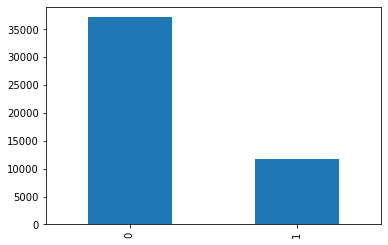

In [58]:
adu_bal = df_adult['class'].value_counts()[1] / df_adult['class'].count()
print(f"{adu_bal * 100:.2f}% {(1 - adu_bal) * 100:.2f}% of disbalancing")

df_adult['class'].value_counts().plot.bar()


counts:
0    9648
1    9648
Name: class, dtype: int64
50.00% 50.00% of disbalancing


<AxesSubplot:>

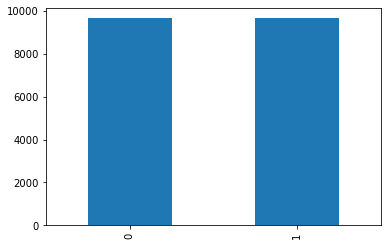

In [59]:
# !pip install imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

smote_tmk = SMOTETomek(sampling_strategy=0.35)
rus = RandomUnderSampler(random_state=0)

df_adult_target = df_adult['class']
df_adult = df_adult.drop(columns=['class'])
# smote oversampling of minority class
df_adult, df_adult_target = smote_tmk.fit_resample(df_adult, df_adult_target)
# random downsampling of majority class
df_adult, df_adult_target = rus.fit_resample(df_adult, df_adult_target)

df_adult = pd.concat([df_adult, df_adult_target], axis=1)

adu_bal = df_adult['class'].value_counts()[0] / df_adult['class'].count()
print(f"counts:\n{df_adult['class'].value_counts()}")
print(f"{adu_bal * 100:.2f}% {(1 - adu_bal) * 100:.2f}% of disbalancing")

df_adult['class'].value_counts().plot.bar()


#### Normalizing

In [60]:
adu_X = df_adult.drop(columns=['class'])
adu_y = df_adult['class']

adu_X = (adu_X - adu_X.mean()) / adu_X.std()

adu_X = adu_X.dropna(axis='columns')

adu_X.head()


age    fnlwgt  education-num       sex  capital-gain  capital-loss  \
0  1.324492 -0.169662      -0.619714 -0.603918     -0.224733     -0.264884   
1 -1.037483 -0.087947       1.269524  1.655768     -0.224733     -0.264884   
2 -0.504134  0.913156      -0.619714 -0.603918     -0.224733     -0.264884   
3 -0.275555 -1.313268      -0.619714 -0.603918     -0.224733     -0.264884   
4 -0.275555 -0.776800      -0.619714 -0.603918     -0.224733     -0.264884   

   hours-per-week  workclass_b'?'  workclass_b'Federal-gov'  \
0       -0.580188       -0.220148                 -0.184162   
1       -0.184916       -0.220148                 -0.184162   
2        2.977254       -0.220148                 -0.184162   
3       -0.184916       -0.220148                 -0.184162   
4        0.210355       -0.220148                 -0.184162   

   workclass_b'Local-gov'  ...  native-country_b'Portugal'  \
0               -0.255326  ...                   -0.033007   
1               -0.255326  ...                   -0.033007   
2               -0.255326  ...                   -0.033007   
3                3.916363  ...                   -0.033007   
4               -0.255326  ...                   -0.033007   

   native-country_b'Puerto-Rico'  native-country_b'Scotland'  \
0                      -0.055379                   -0.020365   
1                      -0.055379                   -0.020365   
2                      -0.055379                   -0.020365   
3                      -0.055379                   -0.020365   
4                      -0.055379                   -0.020365   

   native-country_b'South'  native-country_b'Taiwan'  \
0                -0.047258                 -0.041389   
1                -0.047258                 -0.041389   
2                -0.047258                 -0.041389   
3                -0.047258                 -0.041389   
4                -0.047258                 -0.041389   

   native-country_b'Thailand'  native-country_b'Trinadad&Tobago'  \
0                   -0.020365                          -0.020365   
1                   -0.020365                          -0.020365   
2                   -0.020365                          -0.020365   
3                   -0.020365                          -0.020365   
4                   -0.020365                          -0.020365   

   native-country_b'United-States'  native-country_b'Vietnam'  \
0                         0.337284                  -0.037432   
1                         0.337284                  -0.037432   
2                         0.337284                  -0.037432   
3                         0.337284                  -0.037432   
4                         0.337284                  -0.037432   

   native-country_b'Yugoslavia'  
0                     -0.021601  
1                     -0.021601  
2                     -0.021601  
3                     -0.021601  
4                     -0.021601  

[5 rows x 107 columns]

### Model Training

#### Decision Tree

[0.85181347 0.84507772 0.83056995 0.83160622 0.8373057  0.8357513
 0.8434422  0.83618455 0.84188699 0.83307413]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


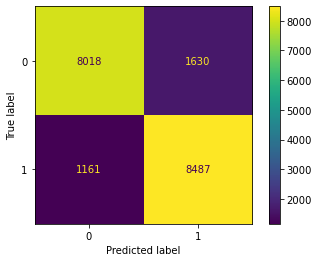

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

adu_dt_params_file = "./params/adu_decision_tree_grided_cv.json"
adu_dt_scores = []

if not exists(adu_dt_params_file):
    # instantiating classifier
    adu_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    adu_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    adu_decision_tree_grided_cv = GridSearchCV(adu_decision_tree_clf, adu_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    adu_decision_tree_grided_cv.fit(adu_X, adu_y)
    # write file with parameters to save on computation next run
    with open(adu_dt_params_file, "w+") as param_f:
        json.dump(adu_decision_tree_grided_cv.best_params_, param_f, indent=4)

        adu_dt_scores = cross_val_score(adu_decision_tree_grided_cv, adu_X, adu_y, cv=10)
        print(adu_dt_scores)
        plot_confusion_matrix(adu_decision_tree_grided_cv, adu_X, adu_y)
else:
    # read params file
    with open(adu_dt_params_file, "r") as param_f:
        # instantiating classifier
        adu_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        adu_decision_tree_grided_cv = adu_decision_tree_clf.fit(adu_X, adu_y)

        adu_dt_scores = cross_val_score(adu_decision_tree_grided_cv, adu_X, adu_y, cv=10)
        print(adu_dt_scores)
        plot_confusion_matrix(adu_decision_tree_grided_cv, adu_X, adu_y)


#### Random Forest

[0.87046632 0.8507772  0.84041451 0.84766839 0.85544041 0.84818653
 0.84655262 0.85847589 0.85743909 0.8911353 ]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


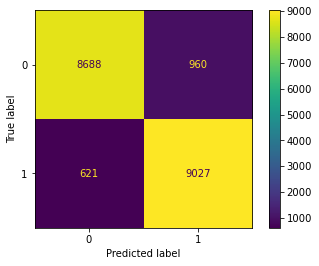

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

adu_rf_params_file = "./params/adu_random_forest_grided_cv.json"
adu_rf_scores = []

if not exists(adu_rf_params_file):
    # instantiating classifier
    adu_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    adu_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    adu_random_forest_grided_cv = GridSearchCV(adu_random_forest_clf, adu_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    adu_random_forest_grided_cv.fit(adu_X, adu_y)

    with open("./params/adu_random_forest_grided_cv.json", "w") as param_f:
        json.dump(adu_random_forest_grided_cv.best_params_, param_f, indent=4)

        adu_rf_scores = cross_val_score(adu_random_forest_grided_cv, adu_X, adu_y, cv=10)
        print(adu_rf_scores)
        plot_confusion_matrix(adu_random_forest_grided_cv, adu_X, adu_y)
else:
    with open(adu_rf_params_file, "r") as param_f:
        # instantiating classifier
        adu_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        adu_random_forest_grided_cv = adu_random_forest_clf.fit(adu_X, adu_y)

        adu_rf_scores = cross_val_score(adu_random_forest_grided_cv, adu_X, adu_y, cv=10)
        print(adu_rf_scores)
        plot_confusion_matrix(adu_random_forest_grided_cv, adu_X, adu_y)


#### KNN

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV 5/10; 1/10] START n_neighbors=25............................................
[CV 5/10; 1/10] END .............n_neighbors=25;, score=0.627 total time= 1.3min
[CV 8/10; 10/10] START n_neighbors=22...........................................
[CV 8/10; 10/10] END ............n_neighbors=22;, score=0.628 total time=  36.7s
[CV 4/10; 5/10] START n_neighbors=30............................................
[CV 4/10; 5/10] END .............n_neighbors=30;, score=0.624 total time= 1.1min
[CV 2/10; 1/10] START n_neighbors=22.....................................

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


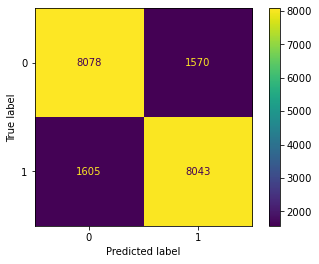

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

adu_knn_params_file = "./params/adu_knn_grided_cv.json"
adu_knn_scores = []

if not exists(adu_knn_params_file):
    # instantiating classifier
    adu_knn_clf = KNeighborsClassifier()
    # defining testing params
    adu_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    adu_knn_grided_cv = GridSearchCV(adu_knn_clf, adu_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    adu_knn_grided_cv.fit(adu_X, adu_y)

    with open("./params/adu_knn_grided_cv.json", "w") as param_f:
        json.dump(adu_knn_grided_cv.best_params_, param_f, indent=4)

        adu_knn_scores = cross_val_score(adu_knn_grided_cv, adu_X, adu_y, cv=10)
        print(adu_knn_scores)
        plot_confusion_matrix(adu_knn_grided_cv, adu_X, adu_y)
else:
    with open(adu_knn_params_file, "r") as param_f:
        # instantiating classifier
        adu_knn_clf = KNeighborsClassifier(**json.load(param_f))
        adu_knn_grided_cv = adu_knn_clf.fit(adu_X, adu_y)

        adu_knn_scores = cross_val_score(adu_knn_grided_cv, adu_X, adu_y, cv=10)
        print(adu_knn_scores)
        plot_confusion_matrix(adu_knn_grided_cv, adu_X, adu_y)


### Model Evaluation

p = 0.0001116658084901137
Rejeita-se a hipótese nula


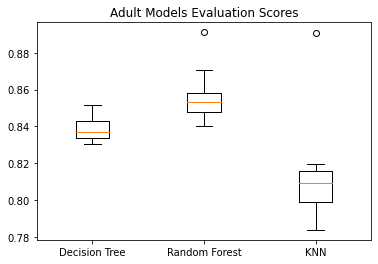

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(adu_dt_scores, adu_rf_scores, adu_knn_scores) 

print(f"p = {p}")
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([adu_dt_scores, adu_rf_scores, adu_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
# plt.ylim(0.8, 1)
plt.title("Adult Models Evaluation Scores")
plt.show()


## AedesSex

### Dataset loading and first look

In [65]:
import pandas as pd

df_aedes = pd.read_csv('./datasets/aedessex.csv')

df_aedes.head()


wbf      eh_1      eh_2      eh_3      eh_4      eh_5      eh_6  \
0  474.193548  0.178585  0.172441  0.043769  0.265499  0.068176  0.128343   
1  495.505618  0.382748  0.383926  0.053126  0.656619  0.175272  0.308242   
2  501.136364  1.110597  1.039894  0.172886  1.392900  0.608041  0.410281   
3  506.896552  0.218450  0.218481  0.027408  0.432591  0.176818  0.229486   
4  565.384615  0.034858  0.058285  0.173607  0.036100  0.377893  0.048056   

       eh_7      eh_8      eh_9  ...     eh_18     eh_19     eh_20     eh_21  \
0  0.028126  0.037949  0.419316  ...  0.017487  0.054026  0.256456  0.284075   
1  0.159714  0.030291  0.110074  ...  0.054666  0.025495  0.026829  0.159360   
2  0.208344  0.051975  0.174283  ...  0.076497  0.034553  0.033132  0.128890   
3  0.091719  0.009900  0.026317  ...  0.024036  0.014079  0.009909  0.036424   
4  0.217498  0.074811  0.023332  ...  0.072753  0.020873  0.028847  0.020273   

      eh_22     eh_23     eh_24     eh_25  sex  temp_range  
0  0.109668  0.027885  0.019769  0.017994    F           1  
1  0.409562  0.273947  0.074906  0.027396    F           1  
2  0.479620  0.453797  0.151702  0.040911    F           1  
3  0.296862  0.341512  0.125294  0.018248    F           1  
4  0.022124  0.027397  0.116446  0.231712    F           1  

[5 rows x 28 columns]

In [66]:
df_aedes.describe()


wbf          eh_1          eh_2          eh_3          eh_4  \
count  24000.000000  24000.000000  24000.000000  24000.000000  24000.000000   
mean     698.061847      0.172435      0.239883      0.260350      0.257254   
std      177.899633      0.195594      0.245362      0.254382      0.278326   
min      108.088235      0.004229      0.004817      0.009122      0.007499   
25%      558.227848      0.050685      0.074270      0.092203      0.078841   
50%      648.529412      0.107268      0.164514      0.188395      0.168815   
75%      848.076923      0.221448      0.318468      0.338421      0.329974   
max     1225.000000      3.050939      3.384026      3.642700      5.018710   

               eh_5          eh_6          eh_7          eh_8          eh_9  \
count  24000.000000  24000.000000  24000.000000  24000.000000  24000.000000   
mean       0.322712      0.247699      0.208674      0.195380      0.192886   
std        0.349547      0.259940      0.230480      0.227332      0.248351   
min        0.006478      0.004713      0.006262      0.006079      0.003202   
25%        0.090025      0.074773      0.053586      0.049789      0.047484   
50%        0.206103      0.166819      0.127101      0.117463      0.100174   
75%        0.424458      0.327554      0.280880      0.257165      0.236039   
max        4.463279      3.793984      3.199406      4.161897      2.892276   

       ...         eh_17         eh_18         eh_19         eh_20  \
count  ...  24000.000000  24000.000000  24000.000000  24000.000000   
mean   ...      0.130928      0.135651      0.140389      0.143489   
std    ...      0.195018      0.199675      0.206210      0.208755   
min    ...      0.005013      0.006455      0.005085      0.004034   
25%    ...      0.031867      0.032831      0.033787      0.033282   
50%    ...      0.060731      0.062206      0.063588      0.061975   
75%    ...      0.134489      0.144456      0.147395      0.153118   
max    ...      3.401515      3.491121      2.866865      2.796163   

              eh_21         eh_22         eh_23         eh_24         eh_25  \
count  24000.000000  24000.000000  24000.000000  24000.000000  24000.000000   
mean       0.147864      0.146633      0.138574      0.131573      0.127364   
std        0.217818      0.218793      0.204806      0.201142      0.195002   
min        0.005109      0.003830      0.004189      0.003833      0.005629   
25%        0.031467      0.030409      0.029776      0.027696      0.027788   
50%        0.058073      0.055071      0.052873      0.049390      0.047741   
75%        0.160280      0.160622      0.153307      0.139322      0.130279   
max        2.689587      2.603801      3.380786      3.067694      2.904592   

         temp_range  
count  24000.000000  
mean       3.500000  
std        1.707861  
min        1.000000  
25%        2.000000  
50%        3.500000  
75%        5.000000  
max        6.000000  

[8 rows x 27 columns]

### Skimming

In [67]:
# !pip install skimpy
from skimpy import skim

skim(df_aedes)


╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types                                           │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                    │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                    │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                    │
│ │ Number of rows    │ 24000  │ │ float64     │ 26    │                                    │
│ │ Number of columns │ 28     │ │ object      │ 1     │                                    │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃          ┃ missing ┃ complete  ┃ mean ┃ sd   ┃ p0     ┃ p25   ┃ p75  ┃ p100 ┃ hist   ┃  │
│ ┃          ┃         ┃ rate      ┃      ┃      ┃        ┃       ┃      ┃      ┃        ┃  │
│ ┡━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ wbf      │       0 │         1 │  700 │  180 │    110 │   560 │  850 │ 1200 │  ▁█▄▄  │  │
│ │ eh_1     │       0 │         1 │ 0.17 │  0.2 │ 0.0042 │ 0.051 │ 0.22 │  3.1 │   █    │  │
│ │ eh_2     │       0 │         1 │ 0.24 │ 0.25 │ 0.0048 │ 0.074 │ 0.32 │  3.4 │   █▁   │  │
│ │ eh_3     │       0 │         1 │ 0.26 │ 0.25 │ 0.0091 │ 0.092 │ 0.34 │  3.6 │   █▁   │  │
│ │ eh_4     │       0 │         1 │ 0.26 │ 0.28 │ 0.0075 │ 0.079 │ 0.33 │    5 │   █    │  │
│ │ eh_5     │       0 │         1 │ 0.32 │ 0.35 │ 0.0065 │  0.09 │ 0.42 │  4.5 │   █▁   │  │
│ │ eh_6     │       0 │         1 │ 0.25 │ 0.26 │ 0.0047 │ 0.075 │ 0.33 │  3.8 │   █▁   │  │
│ │ eh_7     │       0 │         1 │ 0.21 │ 0.23 │ 0.0063 │ 0.054 │ 0.28 │  3.2 │   █▁   │  │
│ │ eh_8     │       0 │         1 │  0.2 │ 0.23 │ 0.0061 │  0.05 │ 0.26 │  4.2 │   █    │  │
│ │ eh_9     │       0 │         1 │ 0.19 │ 0.25 │ 0.0032 │ 0.047 │ 0.24 │  2.9 │   █▁   │  │
│ │ eh_10    │       0 │         1 │ 0.24 │ 0.32 │ 0.0067 │ 0.047 │  0.3 │  5.7 │   █    │  │
│ │ eh_11    │       0 │         1 │ 0.27 │ 0.38 │ 0.0058 │ 0.051 │ 0.34 │    5 │   █▁   │  │
│ │ eh_12    │       0 │         1 │ 0.29 │ 0.39 │ 0.0063 │ 0.049 │ 0.38 │  4.5 │   █▁   │  │
│ │ eh_13    │       0 │         1 │ 0.25 │ 0.33 │ 0.0039 │ 0.048 │ 0.32 │  4.3 │   █▁   │  │
│ │ eh_14    │       0 │         1 │ 0.18 │ 0.25 │ 0.0043 │ 0.043 │ 0.22 │  3.8 │   █    │  │
│ │ eh_15    │       0 │         1 │ 0.14 │ 0.21 │ 0.0065 │ 0.037 │ 0.15 │  3.7 │   █    │  │
│ │ eh_16    │       0 │         1 │ 0.13 │ 0.19 │ 0.0066 │ 0.034 │ 0.13 │  3.6 │   █    │  │
│ │ eh_17    │       0 │         1 │ 0.13 │  0.2 │  0.005 │ 0.032 │ 0.13 │  3.4 │   █    │  │
│ │ eh_18    │       0 │         1 │ 0.14 │  0.2 │ 0.0065 │ 0.033 │ 0.14 │  3.5 │   █    │  │
│ │ eh_19    │       0 │         1 │ 0.14 │ 0.21 │ 0.0051 │ 0.034 │ 0.15 │  2.9 │   █    │  │
│ │ eh_20    │       0 │         1 │ 0.14 │ 0.21 │  0.004 │ 0.033 │ 0.15 │  2.8 │   █    │  │
│ │ eh_21    │       0 │         1 │ 0.15 │ 0.22 │ 0.0051 │ 0.031 │ 0.16 │  2.7 │   █▁   │  │
│ │ eh_22    │       0 │         1 │ 0.15 │ 0.22 │ 0.0038 │  0.03 │ 0.16 │  2.6 │   █▁   │  │
│ │ eh_23    │       0 │         1 │ 0.14 │  0.2 │ 0.0042 │  0.03 │ 0.15 │  3.4 │   █    │  │
│ │ eh_24    │       0 │         1 │ 0.13 │  0.2 │ 0.0038 │ 0.028 │ 0.14 │  3.1 │   █    │  │
│ │ eh_25    │       0 │         1 │ 0.13 │  0.2 │ 0.0056 │ 0.028 │ 0.13 │  2.9 │   █    │  │
│ │ temp_ran │       0 │         1 │  3.5 │  1.7 │      1 │     2 │    5 │    6 │ ██████ │  │
│ │ ge       │         │           │      │      │        │       │      │      │        │  │
│ └──────────┴─────────┴───────────┴──────┴──────┴──

### Preprocessing

#### object columns

In [68]:
aed_obj_cols = list(df_aedes.columns[df_aedes.dtypes == object])

df_aedes[aed_obj_cols].head()


sex
0   F
1   F
2   F
3   F
4   F

In [69]:
df_aedes['sex'].unique()

array(['F', 'M'], dtype=object)

In [70]:
# binarize target class

df_aedes['sex'] = df_aedes['sex'].map({'F': 0, 'M': 1})
df_aedes.head()

wbf      eh_1      eh_2      eh_3      eh_4      eh_5      eh_6  \
0  474.193548  0.178585  0.172441  0.043769  0.265499  0.068176  0.128343   
1  495.505618  0.382748  0.383926  0.053126  0.656619  0.175272  0.308242   
2  501.136364  1.110597  1.039894  0.172886  1.392900  0.608041  0.410281   
3  506.896552  0.218450  0.218481  0.027408  0.432591  0.176818  0.229486   
4  565.384615  0.034858  0.058285  0.173607  0.036100  0.377893  0.048056   

       eh_7      eh_8      eh_9  ...     eh_18     eh_19     eh_20     eh_21  \
0  0.028126  0.037949  0.419316  ...  0.017487  0.054026  0.256456  0.284075   
1  0.159714  0.030291  0.110074  ...  0.054666  0.025495  0.026829  0.159360   
2  0.208344  0.051975  0.174283  ...  0.076497  0.034553  0.033132  0.128890   
3  0.091719  0.009900  0.026317  ...  0.024036  0.014079  0.009909  0.036424   
4  0.217498  0.074811  0.023332  ...  0.072753  0.020873  0.028847  0.020273   

      eh_22     eh_23     eh_24     eh_25  sex  temp_range  
0  0.109668  0.027885  0.019769  0.017994    0           1  
1  0.409562  0.273947  0.074906  0.027396    0           1  
2  0.479620  0.453797  0.151702  0.040911    0           1  
3  0.296862  0.341512  0.125294  0.018248    0           1  
4  0.022124  0.027397  0.116446  0.231712    0           1  

[5 rows x 28 columns]

#### Target class balancing

50.00% 50.00% of disbalancing


<AxesSubplot:>

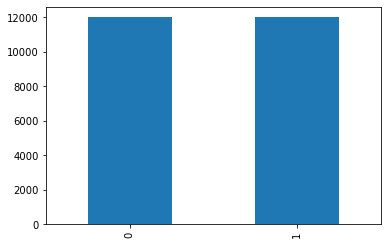

In [71]:
aed_bal = df_aedes['sex'].value_counts()[1] / df_aedes['sex'].count()
print(f"{aed_bal * 100:.2f}% {(1 - aed_bal) * 100:.2f}% of disbalancing")

df_aedes['sex'].value_counts().plot.bar()


#### Normalizing

In [72]:
aed_X = df_aedes.drop(columns=['sex'])
aed_y = df_aedes['sex']

aed_X = (aed_X - aed_X.mean()) / aed_X.std()

aed_X = aed_X.dropna(axis='columns')

aed_X.head()


wbf      eh_1      eh_2      eh_3      eh_4      eh_5      eh_6  \
0 -1.258397  0.031445 -0.274865 -0.851403  0.029622 -0.728188 -0.459166   
1 -1.138598  1.075257  0.587064 -0.814618  1.434881 -0.421802  0.232911   
2 -1.106947  4.796488  3.260534 -0.343830  4.080272  0.816283  0.625459   
3 -1.074568  0.235259 -0.087226 -0.915718  0.629969 -0.417380 -0.070064   
4 -0.745798 -0.703380 -0.740123 -0.340994 -0.794587  0.157864 -0.768035   

       eh_7      eh_8      eh_9  ...     eh_17     eh_18     eh_19     eh_20  \
0 -0.783356 -0.692515  0.911737  ... -0.566096 -0.591783 -0.418814  0.541144   
1 -0.212425 -0.726204 -0.333448  ... -0.500622 -0.405586 -0.557171 -0.558837   
2 -0.001431 -0.630817 -0.074906  ... -0.305588 -0.296251 -0.513244 -0.528647   
3 -0.507440 -0.815899 -0.670701  ... -0.423600 -0.558985 -0.612531 -0.639888   
4  0.038285 -0.530367 -0.682721  ... -0.572164 -0.315000 -0.579583 -0.549170   

      eh_21     eh_22     eh_23     eh_24     eh_25  temp_range  
0  0.625341 -0.168950 -0.540460 -0.555843 -0.560870    -1.46382  
1  0.052777  1.201722  0.660982 -0.281726 -0.512656    -1.46382  
2 -0.087107  1.521921  1.539131  0.100075 -0.443345    -1.46382  
3 -0.511617  0.686623  0.990879 -0.031217 -0.559568    -1.46382  
4 -0.585769 -0.569073 -0.542841 -0.075203  0.535109    -1.46382  

[5 rows x 27 columns]

#### train test split

In [73]:
# from sklearn.model_selection import train_test_split

# aed_X_train, aed_X_test, aed_y_train, aed_y_test = train_test_split(aed_X, aed_y, test_size=0.33, random_state=42)


### Model Training

#### Decision Tree

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 2/10; 18/30] END ............n_neighbors=18;, score=0.805 total time=   0.4s
[CV 6/10; 24/30] START n_neighbors=24...........................................
[CV 6/10; 24/30] END ............n_neighbors=24;, score=0.788 total time=   0.4s
[CV 1/10; 1/30] START n_neighbors=1.............................................
[CV 1/10; 1/30] END ..............n_neighbors=1;, score=0.774 total time=   0.5s
[CV 8/10; 7/30] START n_neighbors=7.............................................
[CV 8/10; 7/30] END ..............n_neighbors=7;, score=0.793 total time=   0.4s
[CV 2/10; 14/30] START n_neighbors=14...........................................
[CV 2/10; 14/30] END ............n_ne

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


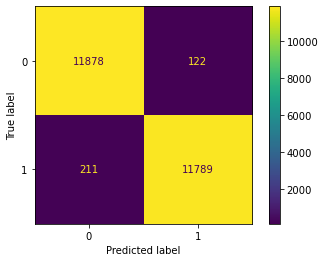

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

aed_dt_params_file = "./params/aed_decision_tree_grided_cv.json"
aed_dt_scores = []

if not exists(aed_dt_params_file):
    # instantiating classifier
    aed_decision_tree_clf = DecisionTreeClassifier(random_state=0)
    # defining testing params
    aed_tree_param = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 120, 150]
    }
    # training on each param combination
    aed_decision_tree_grided_cv = GridSearchCV(aed_decision_tree_clf, aed_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    aed_decision_tree_grided_cv.fit(aed_X, aed_y)
    # write file with parameters to save on computation next run
    with open(aed_dt_params_file, "w+") as param_f:
        json.dump(aed_decision_tree_grided_cv.best_params_, param_f, indent=4)

        aed_dt_scores = cross_val_score(aed_decision_tree_grided_cv, aed_X, aed_y, cv=10)
        print(aed_dt_scores)
        plot_confusion_matrix(aed_decision_tree_grided_cv, aed_X, aed_y)
else:
    # read params file
    with open(aed_dt_params_file, "r") as param_f:
        # instantiating classifier
        aed_decision_tree_clf = DecisionTreeClassifier(random_state=0, **json.load(param_f))
        aed_decision_tree_grided_cv = aed_decision_tree_clf.fit(aed_X, aed_y)

        aed_dt_scores = cross_val_score(aed_decision_tree_grided_cv, aed_X, aed_y, cv=10)
        print(aed_dt_scores)
        plot_confusion_matrix(aed_decision_tree_grided_cv, aed_X, aed_y)


#### Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

aed_rf_params_file = "./params/aed_random_forest_grided_cv.json"
aed_rf_scores = []

if not exists(aed_rf_params_file):
    # instantiating classifier
    aed_random_forest_clf = RandomForestClassifier(random_state=0)
    # defining testing params
    aed_tree_param = {
        'bootstrap': [True, False],
        'max_depth': [10, 20, None], # 30, 40, 50, 60, 70, 80, 90, 100, 
        'max_features': ['sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600] #, 800, 1000, 1200, 1400, 1600, 1800, 2000
    }
    # training on each param combination
    aed_random_forest_grided_cv = GridSearchCV(aed_random_forest_clf, aed_tree_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    aed_random_forest_grided_cv.fit(aed_X, aed_y)

    with open("./params/aed_random_forest_grided_cv.json", "w") as param_f:
        json.dump(aed_random_forest_grided_cv.best_params_, param_f, indent=4)

        aed_rf_scores = cross_val_score(aed_random_forest_grided_cv, aed_X, aed_y, cv=10)
        print(aed_rf_scores)
        plot_confusion_matrix(aed_random_forest_grided_cv, aed_X, aed_y)
else:
    with open(aed_rf_params_file, "r") as param_f:
        # instantiating classifier
        aed_random_forest_clf = RandomForestClassifier(random_state=0, **json.load(param_f))
        aed_random_forest_grided_cv = aed_random_forest_clf.fit(aed_X, aed_y)

        aed_rf_scores = cross_val_score(aed_random_forest_grided_cv, aed_X, aed_y, cv=10)
        print(aed_rf_scores)
        plot_confusion_matrix(aed_random_forest_grided_cv, aed_X, aed_y)


Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV 7/10; 10/36] START criterion=gini, max_depth=15.............................
[CV 7/10; 10/36] END criterion=gini, max_depth=15;, score=0.987 total time=   0.7s
[CV 2/10; 17/36] START criterion=gini, max_depth=120............................
[CV 2/10; 17/36] END criterion=gini, max_depth=120;, score=0.972 total time=   0.6s
[CV 1/10; 24/36] START criterion=entropy, max_depth=9...........................
[CV 1/10; 24/36] END criterion=entropy, max_depth=9;, score=0.950 total time=   0.6s
[CV 6/10; 30/36] START criterion=entropy, max_depth=30..........................
[CV 6/10; 30/36] END criterion=entropy, max_depth=30;, score=0.976 total time=   0.6s
[CV 5/10; 36/36] START criterion=entropy, max_depth=150.........................
[CV 5/10; 36/36] END criterion=entropy, max_depth=150;, score=0.961 total time=   0.7s
[CV 3/10; 7/36] START criterion=gini, max_depth=10..............................
[CV 3/10; 7/36] END crit

exception calling callback for <Future at 0x7f4cf1de8b50 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.10/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/opt/cond

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV 3/10; 1/162] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 3/10; 1/162] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.987 total time=  12.2s
[CV 1/10; 8/162] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400
[CV 1/10; 8/162] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=0.956 total time=  24.2s
[CV 1/10; 13/162] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 1/10; 13/162] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.959 total time=  12.1s
[CV 9/10; 16/162] START bootstrap=True, max_depth=10, max_

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from os.path import exists
import json

aed_knn_params_file = "./params/aed_knn_grided_cv.json"
aed_knn_scores = []

if not exists(aed_knn_params_file):
    # instantiating classifier
    aed_knn_clf = KNeighborsClassifier()
    # defining testing params
    aed_knn_param = dict(n_neighbors=list(range(1, 31)))
    # training on each param combination
    aed_knn_grided_cv = GridSearchCV(aed_knn_clf, aed_knn_param, cv=10, verbose=10, n_jobs=-1)
    # fitting to best params
    aed_knn_grided_cv.fit(aed_X, aed_y)

    with open("./params/aed_knn_grided_cv.json", "w") as param_f:
        json.dump(aed_knn_grided_cv.best_params_, param_f, indent=4)

        aed_knn_scores = cross_val_score(aed_knn_grided_cv, aed_X, aed_y, cv=10)
        print(aed_knn_scores)
        plot_confusion_matrix(aed_knn_grided_cv, aed_X, aed_y)
else:
    with open(aed_knn_params_file, "r") as param_f:
        # instantiating classifier
        aed_knn_clf = KNeighborsClassifier(**json.load(param_f))
        aed_knn_grided_cv = aed_knn_clf.fit(aed_X, aed_y)

        aed_knn_scores = cross_val_score(aed_knn_grided_cv, aed_X, aed_y, cv=10)
        print(aed_knn_scores)
        plot_confusion_matrix(aed_knn_grided_cv, aed_X, aed_y)


### Model Evaluation

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(aed_dt_scores, aed_rf_scores, aed_knn_scores) 

print("p = ", p)
print(f"{'Rejeita' if p < 0.01 else 'Aceita'}-se a hipótese nula")

plt.boxplot([aed_dt_scores, aed_rf_scores, aed_knn_scores], labels=['Decision Tree', 'Random Forest', 'KNN'])
# plt.ylim(0.8, 1)
plt.title("AedesSex Models Evaluation Scores")
plt.show()


In [ ]:
# nemenyi



## Cross Dataset Model Evaluation

In [ ]:
import matplotlib.pyplot as plt

model_scores = []
model_scores.append([arr_dt_scores, arr_rf_scores, arr_knn_scores])
model_scores.append([air_dt_scores, air_rf_scores, air_knn_scores])
model_scores.append([pho_dt_scores, pho_rf_scores, pho_knn_scores])
model_scores.append([phi_dt_scores, phi_rf_scores, phi_knn_scores])
model_scores.append([sat_dt_scores, sat_rf_scores, sat_knn_scores])
model_scores.append([adu_dt_scores, adu_rf_scores, adu_knn_scores])
model_scores.append([aed_dt_scores, aed_rf_scores, aed_knn_scores])

dataset_names = ['Arrythymia', 'Airlines', 'Phoneme', 'Phishing', 'Satellite', 'Adult', 'AedesSex']
model_names = ['Decision Tree', 'Random Forest', 'KNN']
labels = []

for dataset_name in dataset_names:
    for model_name in model_names:
        labels.append(f"{model_name} - {dataset_name}")


plt.boxplot(model_scores, labels=labels)
plt.ylim(0.8, 1)
plt.title("All Models Evaluation Scores")
plt.show()
